In [1]:
import librosa
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import warnings
import sklearn
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
!pip3 install antropy
import antropy
!pip install timbral_models
import timbral_models
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale 
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model, metrics
import pickle



'''
    function: extract_features
    input: path to mp3 files
    output: csv file containing features extracted
    
    This function reads the content in a directory and for each mp3 file detected
    reads the file and extracts relevant features using librosa library for audio
    signal processing
'''

     |████████████████████████████████| 49 kB 7.6 MB/s 
  Created wheel for antropy: filename=antropy-0.1.4-py3-none-any.whl size=16159 sha256=91c1d45ef1acd38db2f3f05ac3c99106821b813b5da98ab33c297d6c7651b2f8
  Stored in directory: /root/.cache/pip/wheels/d4/cc/6b/28fa7036bdabc6f1f92fd6a108ae259dbb48f107f676d6b491
Successfully built antropy
     |████████████████████████████████| 59 kB 7.2 MB/s 
  Created wheel for timbral-models: filename=timbral_models-0.4.0-py3-none-any.whl size=68071 sha256=571074e80eaa740bd7ea8ddeb3e2fe0214050dabfe0544544cea4973da80ca29
  Stored in directory: /root/.cache/pip/wheels/16/28/0d/89d6cb4da30ecf8a9b4b475ba9b26fe3401c295bf6f113e092
Successfully built timbral-models


'\n    function: extract_features\n    input: path to mp3 files\n    output: csv file containing features extracted\n    \n    This function reads the content in a directory and for each mp3 file detected\n    reads the file and extracts relevant features using librosa library for audio\n    signal processing\n'

In [9]:
warnings.filterwarnings('ignore')

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
soundTracks = []
for i in range(1, 111):
    s = str(i)
    while(len(s) < 3):
        s = '0' + s
    soundTracks.append(s)

In [12]:
%cd /content/gdrive/MyDrive/Dataset
%ls

/content/gdrive/MyDrive/Dataset
Emotion_features.csv   mean_ratings_set2.csv  set2_tracklist.csv
Emotion_features.json  Set2/


In [13]:
def generateRmsPlot(audio):
  y, sr = librosa.load(audio)
  rms_values = librosa.feature.rms(y = y, frame_length = int(sr * 0.046),  hop_length = int(sr * 0.046 * 0.5))
  # librosa.display.specshow(rms_values, x_axis = 'time')
  # plt.ylabel('RMS')
  # plt.title('RMS')
  # plt.show()
  S, phase = librosa.magphase(librosa.stft(y))
  rms = librosa.feature.rms(S = S)
  fig, ax = plt.subplots(nrows = 2, sharex = True)
  times = librosa.times_like(rms)
  ax[0].semilogy(times, rms[0], label = 'RMS Energy')
  ax[0].set(xticks = [])
  ax[0].legend()
  ax[0].label_outer()
  librosa.display.specshow(librosa.amplitude_to_db(S, ref = np.max),
                          y_axis = 'log', x_axis = 'time', ax = ax[1])
  ax[1].set(title = 'log Power spectrogram')
  # Use a STFT window of constant ones and no frame centering to get consistent results with the RMS computed from the audio samples y
  S = librosa.magphase(librosa.stft(y, window = np.ones, center = False))[0]
  librosa.feature.rms(S = S)
  plt.show()

In [14]:
def generateSpectralCentroidPlot(audio):
  y, sr = librosa.load(audio)
  spectral_centroid_values = librosa.feature.spectral_centroid(y = y, sr = sr, n_fft = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
  plt.figure(figsize = (20, 5))
  plt.plot(spectral_centroid_values.T)
  plt.title('Spectral centroid')
  plt.ylabel('Hz')
  plt.xlabel('Time')
  plt.show()

In [15]:
def generateSpectralSpreadPlot(audio):
  y, sr = librosa.load(audio)
  spectral_spread_values = librosa.feature.spectral_bandwidth(y = y, sr = sr, win_length = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
  fig, ax = plt.subplots(nrows=2, sharex=True)
  times = librosa.times_like(spectral_spread_values)
  ax[0].semilogy(times, spectral_spread_values[0], label='Spectral bandwidth')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()
  plt.show()

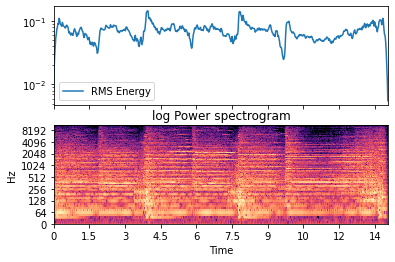

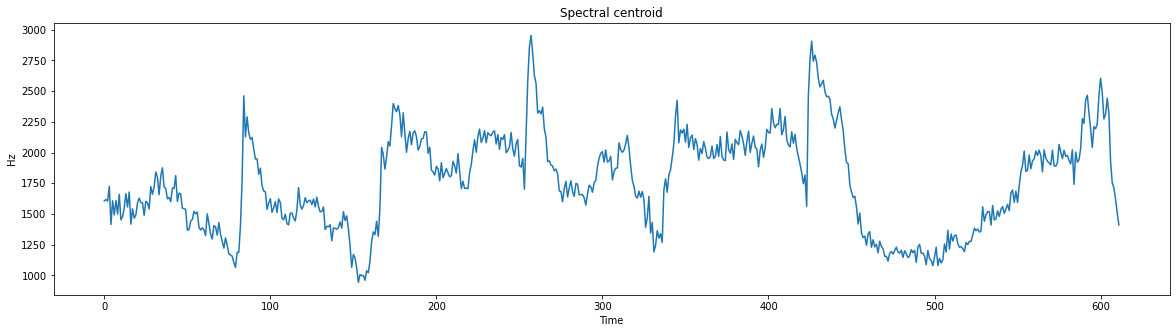

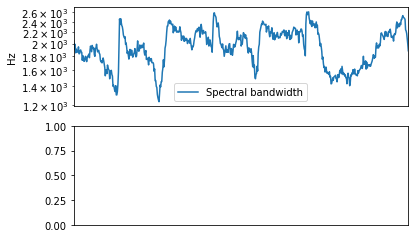

In [16]:
mp3_file = './Set2/set2/' + soundTracks[0] + '.mp3'
generateRmsPlot(mp3_file)
generateSpectralCentroidPlot(mp3_file)
generateSpectralSpreadPlot(mp3_file)

In [52]:
def extract_feature():
    feature_set = pd.DataFrame()  # Feature Matrix
    
    # Individual Feature Vectors
    songname_vector = []
    tempo_vector = []
    total_beats = []
    average_beats = []
    chroma_stft_mean = []
    chroma_stft_std = []
    chroma_stft_var = []
    chroma_cq_mean = []
    chroma_cq_std = []
    chroma_cq_var = []
    chroma_cens_mean = []
    chroma_cens_std = []
    chroma_cens_var = []
    mel_mean = []
    mel_std = []
    mel_var = []
    mfcc_mean = []
    mfcc_std = []
    mfcc_var = []
    mfcc_delta_mean = []
    mfcc_delta_std = []
    mfcc_delta_var = []
    rms_mean = []
    rms_std = []
    rms_var = []
    cent_mean = []
    cent_std = []
    cent_var = []
    spec_bw_mean = []
    spec_bw_std = []
    spec_bw_var = []
    contrast_mean = []
    contrast_std = []
    contrast_var = []
    rolloff_mean = []
    rolloff_std = []
    rolloff_var = []
    entropy_fft = []
    entropy_welch = []
    novelty_mean = []
    novelty_std = []
    novelty_var = []
    poly_mean = []
    poly_std = []
    poly_var = []
    tonnetz_mean = []
    tonnetz_std = []
    tonnetz_var = []
    zcr_mean = []
    zcr_std = []
    zcr_var = []
    harm_mean = []
    harm_std = []
    harm_var = []
    perc_mean = []
    perc_std = []
    perc_var = []
    frame_mean = []
    frame_std = []
    frame_var = []
    
    for sound in soundTracks:
      mp3_file = './Set2/set2/' + sound + '.mp3'
      y, sr = librosa.load(mp3_file)
      S = np.abs(librosa.stft(y))
      
      # Extracting Features
      tempo, beats = librosa.beat.beat_track(y = y, sr = sr, hop_length = int(sr * 0.046 * 0.5))
      chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr, n_fft = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      chroma_cq = librosa.feature.chroma_cqt(y = y, sr = sr)
      chroma_cens = librosa.feature.chroma_cens(y = y, sr = sr)
      melspectrogram = librosa.feature.melspectrogram(y = y, sr = sr, n_fft = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      rms = librosa.feature.rms(y = y, frame_length = int(sr * 0.046),  hop_length = int(sr * 0.046 * 0.5))
      cent = librosa.feature.spectral_centroid(y = y, sr = sr, n_fft = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr, win_length = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      contrast = librosa.feature.spectral_contrast(S = S, sr = sr, n_fft = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr, n_fft = int(sr * 0.046))
      entropy_fft_val = antropy.spectral_entropy(y, sf = sr)
      entropy_welch_val = antropy.spectral_entropy(y, sf = sr, method = 'welch')
      novelty = librosa.onset.onset_strength(y = y, sr = sr, n_fft = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      poly_features = librosa.feature.poly_features(S = S, sr = sr, n_fft = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      tonnetz = librosa.feature.tonnetz(y = y, sr = sr)
      zcr = librosa.feature.zero_crossing_rate(y = y, frame_length = int(sr * 0.046), hop_length = int(sr * 0.046 * 0.5))
      harmonic = librosa.effects.harmonic(y)
      percussive = librosa.effects.percussive(y)
      
      mfcc = librosa.feature.mfcc(y = y, sr = sr)
      mfcc_delta = librosa.feature.delta(mfcc)
  
      onset_frames = librosa.onset.onset_detect(y = y, sr = sr, hop_length = int(sr * 0.046 * 0.5))
      frames_to_time = librosa.frames_to_time(onset_frames[:20], sr = sr)
      

      # Transforming Features
      songname_vector.append(mp3_file)  # song name
      tempo_vector.append(tempo) # tempo
      total_beats.append(sum(beats))  # beats
      average_beats.append(np.average(beats))
      chroma_stft_mean.append(np.mean(chroma_stft))  # chroma stft
      chroma_stft_std.append(np.std(chroma_stft))
      chroma_stft_var.append(np.var(chroma_stft))
      chroma_cq_mean.append(np.mean(chroma_cq)) # chroma cq
      chroma_cq_std.append(np.std(chroma_cq))
      chroma_cq_var.append(np.var(chroma_cq))
      chroma_cens_mean.append(np.mean(chroma_cens))  # chroma cens
      chroma_cens_std.append(np.std(chroma_cens))
      chroma_cens_var.append(np.var(chroma_cens))
      mel_mean.append(np.mean(melspectrogram))  # melspectrogram
      mel_std.append(np.std(melspectrogram))
      mel_var.append(np.var(melspectrogram))
      mfcc_mean.append(np.mean(mfcc))  # mfcc
      mfcc_std.append(np.std(mfcc))
      mfcc_var.append(np.var(mfcc))
      mfcc_delta_mean.append(np.mean(mfcc_delta))  # mfcc delta
      mfcc_delta_std.append(np.std(mfcc_delta))
      mfcc_delta_var.append(np.var(mfcc_delta))
      rms_mean.append(np.mean(rms))  # rms
      rms_std.append(np.std(rms))
      rms_var.append(np.var(rms))
      cent_mean.append(np.mean(cent))  # cent
      cent_std.append(np.std(cent))
      cent_var.append(np.var(cent))
      spec_bw_mean.append(np.mean(spec_bw))  # spectral bandwidth
      spec_bw_std.append(np.std(spec_bw))
      spec_bw_var.append(np.var(spec_bw))
      contrast_mean.append(np.mean(contrast))  # contrast
      contrast_std.append(np.std(contrast))
      contrast_var.append(np.var(contrast))
      rolloff_mean.append(np.mean(rolloff))  # rolloff
      rolloff_std.append(np.std(rolloff))
      rolloff_var.append(np.var(rolloff))
      entropy_fft.append(entropy_fft_val)  # rolloff
      entropy_welch.append(entropy_welch_val)
      novelty_mean.append(np.mean(novelty))  # rolloff
      novelty_std.append(np.std(novelty))
      novelty_var.append(np.var(novelty))
      poly_mean.append(np.mean(poly_features))  # poly features
      poly_std.append(np.std(poly_features))
      poly_var.append(np.var(poly_features))
      tonnetz_mean.append(np.mean(tonnetz))  # tonnetz
      tonnetz_std.append(np.std(tonnetz))
      tonnetz_var.append(np.var(tonnetz))
      zcr_mean.append(np.mean(zcr))  # zero crossing rate
      zcr_std.append(np.std(zcr))
      zcr_var.append(np.var(zcr))
      harm_mean.append(np.mean(harmonic))  # harmonic
      harm_std.append(np.std(harmonic))
      harm_var.append(np.var(harmonic))
      perc_mean.append(np.mean(percussive))  # percussive
      perc_std.append(np.std(percussive))
      perc_var.append(np.var(percussive))
      frame_mean.append(np.mean(frames_to_time))  # frames
      frame_std.append(np.std(frames_to_time))
      frame_var.append(np.var(frames_to_time))
      
      print(mp3_file)

    # Concatenating Features into one csv and json format
    feature_set['song_name'] = songname_vector  # song name
    feature_set['tempo'] = tempo_vector  # tempo 
    feature_set['total_beats'] = total_beats  # beats
    feature_set['average_beats'] = average_beats
    feature_set['chroma_stft_mean'] = chroma_stft_mean  # chroma stft
    feature_set['chroma_stft_std'] = chroma_stft_std
    feature_set['chroma_stft_var'] = chroma_stft_var
    feature_set['chroma_cq_mean'] = chroma_cq_mean  # chroma cq
    feature_set['chroma_cq_std'] = chroma_cq_std
    feature_set['chroma_cq_var'] = chroma_cq_var
    feature_set['chroma_cens_mean'] = chroma_cens_mean  # chroma cens
    feature_set['chroma_cens_std'] = chroma_cens_std
    feature_set['chroma_cens_var'] = chroma_cens_var
    feature_set['melspectrogram_mean'] = mel_mean  # melspectrogram
    feature_set['melspectrogram_std'] = mel_std
    feature_set['melspectrogram_var'] = mel_var
    feature_set['mfcc_mean'] = mfcc_mean  # mfcc
    feature_set['mfcc_std'] = mfcc_std
    feature_set['mfcc_var'] = mfcc_var
    feature_set['mfcc_delta_mean'] = mfcc_delta_mean  # mfcc delta
    feature_set['mfcc_delta_std'] = mfcc_delta_std
    feature_set['mfcc_delta_var'] = mfcc_delta_var
    feature_set['rms_mean'] = rms_mean  # rms
    feature_set['rms_std'] = rms_std
    feature_set['rms_var'] = rms_var
    feature_set['cent_mean'] = cent_mean  # cent
    feature_set['cent_std'] = cent_std
    feature_set['cent_var'] = cent_var
    feature_set['spec_bw_mean'] = spec_bw_mean  # spectral bandwidth
    feature_set['spec_bw_std'] = spec_bw_std
    feature_set['spec_bw_var'] = spec_bw_var
    feature_set['contrast_mean'] = contrast_mean  # contrast
    feature_set['contrast_std'] = contrast_std
    feature_set['contrast_var'] = contrast_var
    feature_set['rolloff_mean'] = rolloff_mean  # rolloff
    feature_set['rolloff_std'] = rolloff_std
    feature_set['rolloff_var'] = rolloff_var
    feature_set['entropy_fft'] = entropy_fft
    feature_set['entropy_welch'] = entropy_welch
    feature_set['novelty_mean'] = novelty_mean  # rolloff
    feature_set['novelty_std'] = novelty_std
    feature_set['novelty_var'] = novelty_var
    feature_set['poly_mean'] = poly_mean  # poly features
    feature_set['poly_std'] = poly_std
    feature_set['poly_var'] = poly_var
    feature_set['tonnetz_mean'] = tonnetz_mean  # tonnetz
    feature_set['tonnetz_std'] = tonnetz_std
    feature_set['tonnetz_var'] = tonnetz_var
    feature_set['zcr_mean'] = zcr_mean  # zero crossing rate
    feature_set['zcr_std'] = zcr_std
    feature_set['zcr_var'] = zcr_var
    feature_set['harm_mean'] = harm_mean  # harmonic
    feature_set['harm_std'] = harm_std
    feature_set['harm_var'] = harm_var
    feature_set['perc_mean'] = perc_mean  # percussive
    feature_set['perc_std'] = perc_std
    feature_set['perc_var'] = perc_var
    feature_set['frame_mean'] = frame_mean  # frames
    feature_set['frame_std'] = frame_std
    feature_set['frame_var'] = frame_var
    feature_set.to_csv('Emotion_features.csv', index=False)
    feature_set.to_csv('Emotion_features_temp.csv')
    feature_set.to_json('Emotion_features.json')

    return feature_set

In [53]:
df = extract_feature()
# df = pd.read_csv('Emotion_features.csv')

./Set2/set2/001.mp3
./Set2/set2/002.mp3
./Set2/set2/003.mp3
./Set2/set2/004.mp3
./Set2/set2/005.mp3
./Set2/set2/006.mp3
./Set2/set2/007.mp3
./Set2/set2/008.mp3
./Set2/set2/009.mp3
./Set2/set2/010.mp3
./Set2/set2/011.mp3
./Set2/set2/012.mp3
./Set2/set2/013.mp3
./Set2/set2/014.mp3
./Set2/set2/015.mp3
./Set2/set2/016.mp3
./Set2/set2/017.mp3
./Set2/set2/018.mp3
./Set2/set2/019.mp3
./Set2/set2/020.mp3
./Set2/set2/021.mp3
./Set2/set2/022.mp3
./Set2/set2/023.mp3
./Set2/set2/024.mp3
./Set2/set2/025.mp3
./Set2/set2/026.mp3
./Set2/set2/027.mp3
./Set2/set2/028.mp3
./Set2/set2/029.mp3
./Set2/set2/030.mp3
./Set2/set2/031.mp3
./Set2/set2/032.mp3
./Set2/set2/033.mp3
./Set2/set2/034.mp3
./Set2/set2/035.mp3
./Set2/set2/036.mp3
./Set2/set2/037.mp3
./Set2/set2/038.mp3
./Set2/set2/039.mp3
./Set2/set2/040.mp3
./Set2/set2/041.mp3
./Set2/set2/042.mp3
./Set2/set2/043.mp3
./Set2/set2/044.mp3
./Set2/set2/045.mp3
./Set2/set2/046.mp3
./Set2/set2/047.mp3
./Set2/set2/048.mp3
./Set2/set2/049.mp3
./Set2/set2/050.mp3


In [56]:
df

,song_name,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_std,chroma_stft_var,chroma_cq_mean,chroma_cq_std,chroma_cq_var,...,zcr_var,harm_mean,harm_std,harm_var,perc_mean,perc_std,perc_var,frame_mean,frame_std,frame_var
0,./Set2/set2/001.mp3,113.455107,5816,252.869565,0.421596,0.279414,0.078072,0.446621,0.283678,0.080473,...,0.001220,-4.665987e-04,0.093550,0.008752,-0.001787,0.037512,0.001407,4.576911,2.788252,7.774352
1,./Set2/set2/002.mp3,124.260355,7067,271.807692,0.419036,0.302399,0.091445,0.416257,0.277950,0.077256,...,0.001476,-2.860819e-05,0.084647,0.007165,0.000016,0.048022,0.002306,7.956704,4.090166,16.729461
2,./Set2/set2/003.mp3,153.498086,11072,299.243243,0.558843,0.249044,0.062023,0.544370,0.223418,0.049915,...,0.000445,-3.119903e-07,0.043094,0.001857,-0.000016,0.028662,0.000821,3.094059,1.500355,2.251066
3,./Set2/set2/004.mp3,108.727811,5642,256.454545,0.428870,0.288276,0.083103,0.306902,0.279795,0.078285,...,0.001259,7.716396e-07,0.065245,0.004257,-0.000010,0.012110,0.000147,6.238428,5.237909,27.435687
4,./Set2/set2/005.mp3,59.306079,4013,286.642857,0.569062,0.234119,0.054812,0.505485,0.244390,0.059727,...,0.000511,-5.747839e-07,0.071596,0.005126,-0.000011,0.037861,0.001433,7.690965,3.893232,15.157256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,./Set2/set2/106.mp3,63.645548,3953,282.357143,0.451871,0.284917,0.081178,0.274822,0.269697,0.072737,...,0.000631,-8.153330e-04,0.028351,0.000804,-0.000815,0.009441,0.000089,6.532934,3.342885,11.174883
106,./Set2/set2/107.mp3,144.970414,11734,317.135135,0.374579,0.274591,0.075400,0.224037,0.278579,0.077606,...,0.000538,-4.166433e-03,0.041536,0.001725,-0.000354,0.004571,0.000021,3.701261,2.113544,4.467068
107,./Set2/set2/108.mp3,79.074771,5902,310.631579,0.357136,0.304720,0.092854,0.316686,0.287873,0.082871,...,0.000103,-5.510016e-06,0.033045,0.001092,-0.000018,0.007403,0.000055,2.527492,1.901717,3.616527
108,./Set2/set2/109.mp3,89.981636,4717,277.470588,0.263624,0.312115,0.097416,0.209426,0.271907,0.073933,...,0.000085,-2.570422e-07,0.020940,0.000438,-0.000016,0.001778,0.000003,2.224472,1.246840,1.554611


In [58]:
df = pd.read_csv('Emotion_features.csv')
df

,song_name,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_std,chroma_stft_var,chroma_cq_mean,chroma_cq_std,chroma_cq_var,...,zcr_var,harm_mean,harm_std,harm_var,perc_mean,perc_std,perc_var,frame_mean,frame_std,frame_var
0,./Set2/set2/001.mp3,113.455107,5816,252.869565,0.421596,0.279414,0.078072,0.446621,0.283678,0.080473,...,0.001220,-4.665987e-04,0.093550,0.008752,-0.001787,0.037512,0.001407,4.576911,2.788252,7.774352
1,./Set2/set2/002.mp3,124.260355,7067,271.807692,0.419036,0.302399,0.091445,0.416257,0.277950,0.077256,...,0.001476,-2.860819e-05,0.084647,0.007165,0.000016,0.048022,0.002306,7.956704,4.090166,16.729461
2,./Set2/set2/003.mp3,153.498086,11072,299.243243,0.558843,0.249044,0.062023,0.544370,0.223418,0.049915,...,0.000445,-3.119903e-07,0.043094,0.001857,-0.000016,0.028662,0.000821,3.094059,1.500355,2.251066
3,./Set2/set2/004.mp3,108.727811,5642,256.454545,0.428870,0.288276,0.083103,0.306902,0.279795,0.078285,...,0.001259,7.716396e-07,0.065245,0.004257,-0.000010,0.012110,0.000147,6.238428,5.237909,27.435687
4,./Set2/set2/005.mp3,59.306079,4013,286.642857,0.569062,0.234119,0.054812,0.505485,0.244390,0.059727,...,0.000511,-5.747839e-07,0.071596,0.005126,-0.000011,0.037861,0.001433,7.690965,3.893232,15.157256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,./Set2/set2/106.mp3,63.645548,3953,282.357143,0.451871,0.284917,0.081178,0.274822,0.269697,0.072737,...,0.000631,-8.153330e-04,0.028351,0.000804,-0.000815,0.009441,0.000089,6.532934,3.342885,11.174883
106,./Set2/set2/107.mp3,144.970414,11734,317.135135,0.374579,0.274591,0.075400,0.224037,0.278579,0.077606,...,0.000538,-4.166433e-03,0.041536,0.001725,-0.000354,0.004571,0.000021,3.701261,2.113544,4.467068
107,./Set2/set2/108.mp3,79.074771,5902,310.631579,0.357136,0.304720,0.092854,0.316686,0.287873,0.082871,...,0.000103,-5.510016e-06,0.033045,0.001092,-0.000018,0.007403,0.000055,2.527492,1.901717,3.616527
108,./Set2/set2/109.mp3,89.981636,4717,277.470588,0.263624,0.312115,0.097416,0.209426,0.271907,0.073933,...,0.000085,-2.570422e-07,0.020940,0.000438,-0.000016,0.001778,0.000003,2.224472,1.246840,1.554611


In [63]:
audio_info_df = pd.read_csv('mean_ratings_set2.csv')
audio_info_df

,Number,valence,energy,tension,anger,fear,happy,sad,tender,beauty,liking,TARGET,Soundtrack,Index in Set 1
0,1,2.56,7.73,8.38,6.39,4.40,1.21,1.75,1.01,4.71,4.97,ANGER_HIGH,Lethal weapon 3,227
1,2,2.50,8.21,8.56,5.76,5.93,1.09,1.60,1.10,4.57,4.79,ANGER_HIGH,The Rainmaker,124
2,3,2.92,8.21,8.17,6.31,4.06,1.31,1.55,1.01,4.45,5.06,ANGER_HIGH,The Alien Trilogy,125
3,4,2.88,6.75,7.98,5.42,4.51,1.19,2.10,1.06,4.00,4.35,ANGER_HIGH,Cape Fear,168
4,5,3.08,6.83,7.50,6.13,4.24,1.07,2.96,1.07,5.08,5.35,ANGER_HIGH,The Fifth Element,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,106,7.37,3.73,2.21,1.00,1.00,3.13,2.45,6.57,6.30,5.93,TENSION NEG HIGH,Lethal weapon 3,333
106,107,7.09,4.21,2.75,1.00,1.09,4.26,2.43,5.89,6.34,5.36,TENSION NEG HIGH,The Godfarher,191
107,108,5.87,2.97,3.54,1.02,1.45,1.17,5.13,4.09,6.38,5.94,TENSION NEG HIGH,Gladiator,45
108,109,5.37,2.28,3.22,1.13,1.45,1.02,7.00,3.47,6.72,6.08,TENSION NEG HIGH,Pride & Prejudice,278


In [79]:
audio_df = pd.concat([audio_info_df, df], axis = 1)

In [80]:
audio_df.columns

Index(['Number', 'valence', 'energy', 'tension', 'anger', 'fear', 'happy',
       'sad', 'tender', 'beauty', 'liking', 'TARGET', 'Soundtrack',
       'Index in Set 1', 'song_name', 'tempo', 'total_beats', 'average_beats',
       'chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_var',
       'chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var', 'chroma_cens_mean',
       'chroma_cens_std', 'chroma_cens_var', 'melspectrogram_mean',
       'melspectrogram_std', 'melspectrogram_var', 'mfcc_mean', 'mfcc_std',
       'mfcc_var', 'mfcc_delta_mean', 'mfcc_delta_std', 'mfcc_delta_var',
       'rms_mean', 'rms_std', 'rms_var', 'cent_mean', 'cent_std', 'cent_var',
       'spec_bw_mean', 'spec_bw_std', 'spec_bw_var', 'contrast_mean',
       'contrast_std', 'contrast_var', 'rolloff_mean', 'rolloff_std',
       'rolloff_var', 'entropy_fft', 'entropy_welch', 'novelty_mean',
       'novelty_std', 'novelty_var', 'poly_mean', 'poly_std', 'poly_var',
       'tonnetz_mean', 'tonnetz_std', 'tonnetz_var', '

In [81]:
audio_df.drop(['Number', 'Index in Set 1', 'song_name'], axis = 1, inplace = True)

In [82]:
audio_df.columns

Index(['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad',
       'tender', 'beauty', 'liking', 'TARGET', 'Soundtrack', 'tempo',
       'total_beats', 'average_beats', 'chroma_stft_mean', 'chroma_stft_std',
       'chroma_stft_var', 'chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var',
       'chroma_cens_mean', 'chroma_cens_std', 'chroma_cens_var',
       'melspectrogram_mean', 'melspectrogram_std', 'melspectrogram_var',
       'mfcc_mean', 'mfcc_std', 'mfcc_var', 'mfcc_delta_mean',
       'mfcc_delta_std', 'mfcc_delta_var', 'rms_mean', 'rms_std', 'rms_var',
       'cent_mean', 'cent_std', 'cent_var', 'spec_bw_mean', 'spec_bw_std',
       'spec_bw_var', 'contrast_mean', 'contrast_std', 'contrast_var',
       'rolloff_mean', 'rolloff_std', 'rolloff_var', 'entropy_fft',
       'entropy_welch', 'novelty_mean', 'novelty_std', 'novelty_var',
       'poly_mean', 'poly_std', 'poly_var', 'tonnetz_mean', 'tonnetz_std',
       'tonnetz_var', 'zcr_mean', 'zcr_std', 'zcr_var', 'harm_me

In [83]:
first_column = audio_df.pop('Soundtrack')
audio_df.insert(0, 'soundtrack', first_column)  
last_column = audio_df.pop('TARGET')
audio_df.insert(audio_df.shape[1], 'target', last_column)

In [84]:
audio_df

,soundtrack,valence,energy,tension,anger,fear,happy,sad,tender,beauty,...,harm_mean,harm_std,harm_var,perc_mean,perc_std,perc_var,frame_mean,frame_std,frame_var,target
0,Lethal weapon 3,2.56,7.73,8.38,6.39,4.40,1.21,1.75,1.01,4.71,...,-4.665987e-04,0.093550,0.008752,-0.001787,0.037512,0.001407,4.576911,2.788252,7.774352,ANGER_HIGH
1,The Rainmaker,2.50,8.21,8.56,5.76,5.93,1.09,1.60,1.10,4.57,...,-2.860819e-05,0.084647,0.007165,0.000016,0.048022,0.002306,7.956704,4.090166,16.729461,ANGER_HIGH
2,The Alien Trilogy,2.92,8.21,8.17,6.31,4.06,1.31,1.55,1.01,4.45,...,-3.119903e-07,0.043094,0.001857,-0.000016,0.028662,0.000821,3.094059,1.500355,2.251066,ANGER_HIGH
3,Cape Fear,2.88,6.75,7.98,5.42,4.51,1.19,2.10,1.06,4.00,...,7.716396e-07,0.065245,0.004257,-0.000010,0.012110,0.000147,6.238428,5.237909,27.435687,ANGER_HIGH
4,The Fifth Element,3.08,6.83,7.50,6.13,4.24,1.07,2.96,1.07,5.08,...,-5.747839e-07,0.071596,0.005126,-0.000011,0.037861,0.001433,7.690965,3.893232,15.157256,ANGER_HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Lethal weapon 3,7.37,3.73,2.21,1.00,1.00,3.13,2.45,6.57,6.30,...,-8.153330e-04,0.028351,0.000804,-0.000815,0.009441,0.000089,6.532934,3.342885,11.174883,TENSION NEG HIGH
106,The Godfarher,7.09,4.21,2.75,1.00,1.09,4.26,2.43,5.89,6.34,...,-4.166433e-03,0.041536,0.001725,-0.000354,0.004571,0.000021,3.701261,2.113544,4.467068,TENSION NEG HIGH
107,Gladiator,5.87,2.97,3.54,1.02,1.45,1.17,5.13,4.09,6.38,...,-5.510016e-06,0.033045,0.001092,-0.000018,0.007403,0.000055,2.527492,1.901717,3.616527,TENSION NEG HIGH
108,Pride & Prejudice,5.37,2.28,3.22,1.13,1.45,1.02,7.00,3.47,6.72,...,-2.570422e-07,0.020940,0.000438,-0.000016,0.001778,0.000003,2.224472,1.246840,1.554611,TENSION NEG HIGH


In [85]:
audio_df = audio_df.dropna(how='any',axis=0) 

In [86]:
audio_df.columns

Index(['soundtrack', 'valence', 'energy', 'tension', 'anger', 'fear', 'happy',
       'sad', 'tender', 'beauty', 'liking', 'tempo', 'total_beats',
       'average_beats', 'chroma_stft_mean', 'chroma_stft_std',
       'chroma_stft_var', 'chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var',
       'chroma_cens_mean', 'chroma_cens_std', 'chroma_cens_var',
       'melspectrogram_mean', 'melspectrogram_std', 'melspectrogram_var',
       'mfcc_mean', 'mfcc_std', 'mfcc_var', 'mfcc_delta_mean',
       'mfcc_delta_std', 'mfcc_delta_var', 'rms_mean', 'rms_std', 'rms_var',
       'cent_mean', 'cent_std', 'cent_var', 'spec_bw_mean', 'spec_bw_std',
       'spec_bw_var', 'contrast_mean', 'contrast_std', 'contrast_var',
       'rolloff_mean', 'rolloff_std', 'rolloff_var', 'entropy_fft',
       'entropy_welch', 'novelty_mean', 'novelty_std', 'novelty_var',
       'poly_mean', 'poly_std', 'poly_var', 'tonnetz_mean', 'tonnetz_std',
       'tonnetz_var', 'zcr_mean', 'zcr_std', 'zcr_var', 'harm_mean',
     

In [87]:
audio_df

,soundtrack,valence,energy,tension,anger,fear,happy,sad,tender,beauty,...,harm_mean,harm_std,harm_var,perc_mean,perc_std,perc_var,frame_mean,frame_std,frame_var,target
0,Lethal weapon 3,2.56,7.73,8.38,6.39,4.40,1.21,1.75,1.01,4.71,...,-4.665987e-04,0.093550,0.008752,-0.001787,0.037512,0.001407,4.576911,2.788252,7.774352,ANGER_HIGH
1,The Rainmaker,2.50,8.21,8.56,5.76,5.93,1.09,1.60,1.10,4.57,...,-2.860819e-05,0.084647,0.007165,0.000016,0.048022,0.002306,7.956704,4.090166,16.729461,ANGER_HIGH
2,The Alien Trilogy,2.92,8.21,8.17,6.31,4.06,1.31,1.55,1.01,4.45,...,-3.119903e-07,0.043094,0.001857,-0.000016,0.028662,0.000821,3.094059,1.500355,2.251066,ANGER_HIGH
3,Cape Fear,2.88,6.75,7.98,5.42,4.51,1.19,2.10,1.06,4.00,...,7.716396e-07,0.065245,0.004257,-0.000010,0.012110,0.000147,6.238428,5.237909,27.435687,ANGER_HIGH
4,The Fifth Element,3.08,6.83,7.50,6.13,4.24,1.07,2.96,1.07,5.08,...,-5.747839e-07,0.071596,0.005126,-0.000011,0.037861,0.001433,7.690965,3.893232,15.157256,ANGER_HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Lethal weapon 3,7.37,3.73,2.21,1.00,1.00,3.13,2.45,6.57,6.30,...,-8.153330e-04,0.028351,0.000804,-0.000815,0.009441,0.000089,6.532934,3.342885,11.174883,TENSION NEG HIGH
106,The Godfarher,7.09,4.21,2.75,1.00,1.09,4.26,2.43,5.89,6.34,...,-4.166433e-03,0.041536,0.001725,-0.000354,0.004571,0.000021,3.701261,2.113544,4.467068,TENSION NEG HIGH
107,Gladiator,5.87,2.97,3.54,1.02,1.45,1.17,5.13,4.09,6.38,...,-5.510016e-06,0.033045,0.001092,-0.000018,0.007403,0.000055,2.527492,1.901717,3.616527,TENSION NEG HIGH
108,Pride & Prejudice,5.37,2.28,3.22,1.13,1.45,1.02,7.00,3.47,6.72,...,-2.570422e-07,0.020940,0.000438,-0.000016,0.001778,0.000003,2.224472,1.246840,1.554611,TENSION NEG HIGH


# Regression

### Multiple Linear Regression(without Transformation) 

valence
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.4859503549385196
R2:  0.20072610804200286
--------------------------------------------------
Actual ---> Predicted
5.88 ---> 5.59
2.38 ---> 3.85
3.08 ---> 4.29
4.28 ---> 5.89
3.03 ---> 4.43
2.04 ---> 5.85
5.02 ---> 5.89
7.23 ---> 5.68
5.46 ---> 4.81
3.6 ---> 5.39
5.19 ---> 6.18
5.24 ---> 5.41
2.56 ---> 5.04
6.4 ---> 6.2
4.58 ---> 5.57
7.45 ---> 5.94
6.03 ---> 5.79
7.25 ---> 5.61
5.37 ---> 6.49
7.38 ---> 6.16
3.19 ---> 4.78
4.73 ---> 3.98
--------------------------------------------------
Coefficients:  [-3.57046423e-07  5.07649551e-06  4.71287905e-06 -2.36782921e-06
  3.37249456e-05 -7.31291421e-05 -1.67076296e-03 -2.84513623e-03
  2.48274563e-03  4.93457297e-03 -7.25082262e-03  8.39747133e-03]


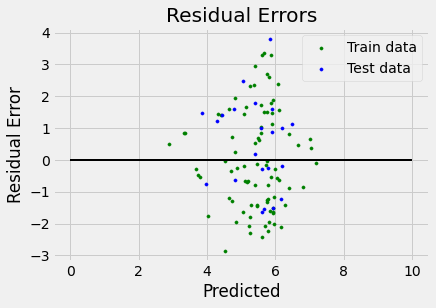

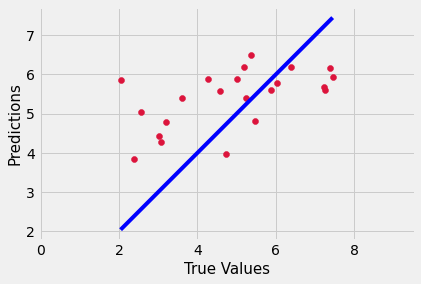

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
energy
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.4831515564204956
R2:  0.3577927951402222
--------------------------------------------------
Actual ---> Predicted
6.78 ---> 4.37
6.38 ---> 6.1
6.83 ---> 7.09
3.88 ---> 5.1
5.12 ---> 6.15
4.54 ---> 8.53
3.19 ---> 4.94
4.23 ---> 5.8
4.78 ---> 5.45
7.42 ---> 6.18
2.99 ---> 4.26
3.7 ---> 6.08
7.73 ---> 7.32
4.49 ---> 4.94
4.83 ---> 5.74
8.39 ---> 7.24
3.82 ---> 4.53
8.12 ---> 7.41
2.28 ---> 2.28
3.21 ---> 4.48
7.1 ---> 5.11
2.79 ---> 2.61
--------------------------------------------------
Coefficients:  [ 2.72389614e-07 -9.60734286e-07  5.59407858e-07  3.95421112e-05
 -3.58182412e-04  1.39961765e-04 -5.59

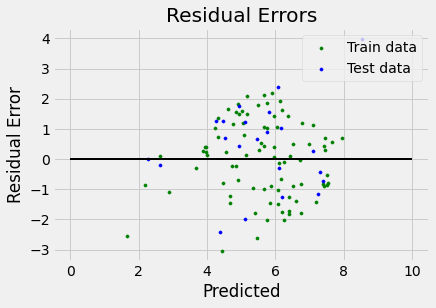

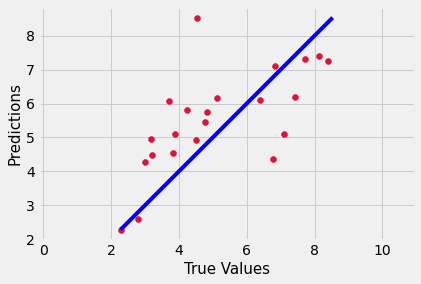

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tension
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.3711231573703468
R2:  0.4826957065760229
--------------------------------------------------
Actual ---> Predicted
6.1 ---> 4.64
8.33 ---> 7.07
7.5 ---> 7.06
5.84 ---> 4.62
7.58 ---> 6.63
7.76 ---> 7.41
3.65 ---> 4.85
2.63 ---> 5.19
5.57 ---> 6.03
8.06 ---> 5.89
4.43 ---> 4.32
4.79 ---> 5.88
8.38 ---> 6.68
4.6 ---> 4.29
6.81 ---> 5.26
5.61 ---> 5.95
4.31 ---> 4.81
5.03 ---> 6.18
3.22 ---> 2.48
1.85 ---> 4.63
8.15 ---> 5.86
4.6 ---> 5.09
--------------------------------------------------
Coefficients:  [ 4.55819621e-07 -4.51287441e-06 -3.63975120e-06  2.31464635e-05
 -2.08095899e-04  1.54672442e-04  1.

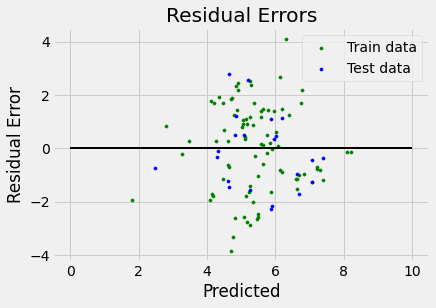

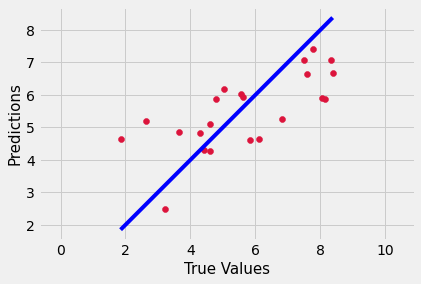

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
anger
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.1241645148042478
R2:  0.419008539368104
--------------------------------------------------
Actual ---> Predicted
1.06 ---> 1.36
2.79 ---> 3.51
6.13 ---> 3.7
1.96 ---> 1.68
2.11 ---> 2.56
2.17 ---> 2.65
1.1 ---> 1.3
1.03 ---> 2.18
1.3 ---> 2.15
2.28 ---> 1.69
1.04 ---> 0.54
1.06 ---> 1.76
6.39 ---> 2.66
1.0 ---> 0.67
1.34 ---> 1.94
1.19 ---> 1.96
1.06 ---> 1.07
1.26 ---> 2.59
1.13 ---> 0.31
1.01 ---> 0.91
2.13 ---> 1.86
1.09 ---> 1.37
--------------------------------------------------
Coefficients:  [ 3.96599977e-07 -5.36106302e-06 -2.51296860e-06  4.12061798e-05
 -1.68901618e-04  9.46164477e-06  2.7920

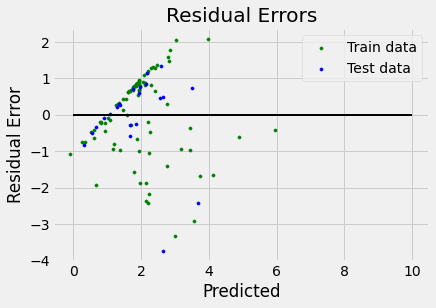

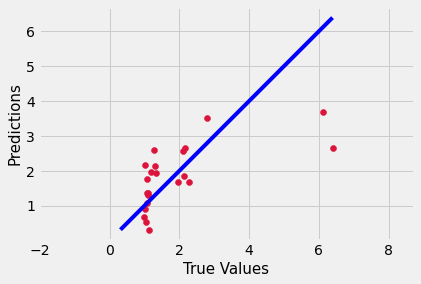

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
fear
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.7563863956064885
R2:  0.26828038239227436
--------------------------------------------------
Actual ---> Predicted
2.02 ---> 2.5
7.42 ---> 4.17
4.24 ---> 4.06
3.13 ---> 2.25
6.19 ---> 3.87
6.17 ---> 2.4
1.69 ---> 1.99
1.21 ---> 2.6
2.19 ---> 3.34
6.12 ---> 2.64
2.02 ---> 1.51
1.43 ---> 2.54
4.4 ---> 3.15
1.23 ---> 1.86
2.93 ---> 2.67
1.17 ---> 2.14
1.51 ---> 1.83
1.19 ---> 2.62
1.45 ---> 1.67
1.1 ---> 2.18
6.34 ---> 3.07
2.16 ---> 3.83
--------------------------------------------------
Coefficients:  [ 2.92126387e-07 -5.00625498e-06 -4.80515637e-06 -8.06770028e-06
 -7.26721275e-05 -4.19188969e-05  8.125

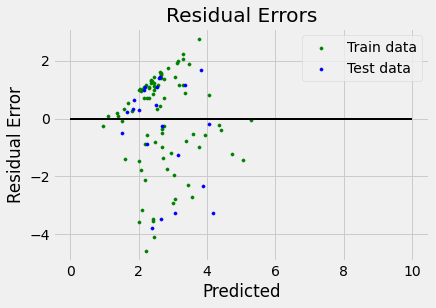

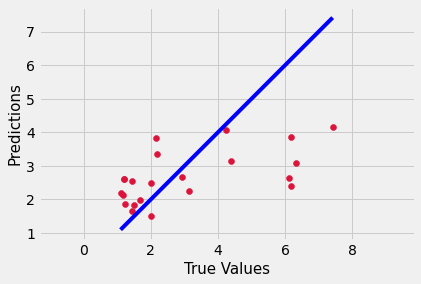

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
happy
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.7913638266628373
R2:  -0.056170691056173006
--------------------------------------------------
Actual ---> Predicted
4.0 ---> 2.16
1.09 ---> 1.6
1.07 ---> 2.24
1.02 ---> 2.9
1.28 ---> 2.21
1.04 ---> 5.66
1.25 ---> 2.83
3.75 ---> 3.13
1.79 ---> 2.21
1.28 ---> 3.16
1.04 ---> 2.63
1.36 ---> 3.05
1.21 ---> 3.41
2.43 ---> 3.1
1.49 ---> 3.11
7.34 ---> 4.36
1.77 ---> 2.42
6.6 ---> 3.97
1.02 ---> 1.76
2.85 ---> 3.12
1.31 ---> 1.85
1.15 ---> -0.53
--------------------------------------------------
Coefficients:  [-1.63584042e-07  5.40647355e-06  5.89866635e-06  2.21152121e-05
 -1.68173627e-04  4.87305386e-05 -2

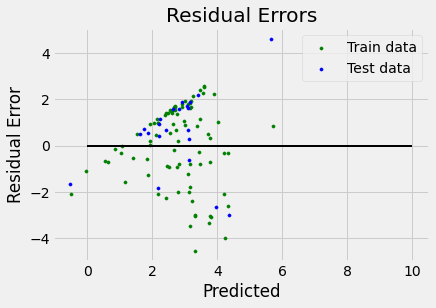

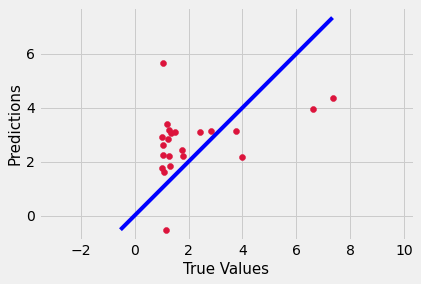

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
sad
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.6383816174336592
R2:  0.266054634488754
--------------------------------------------------
Actual ---> Predicted
1.81 ---> 3.55
1.6 ---> 2.29
2.96 ---> 1.67
5.94 ---> 2.99
1.55 ---> 2.63
1.68 ---> -0.05
6.78 ---> 3.36
3.52 ---> 2.45
3.19 ---> 2.98
1.57 ---> 2.82
6.17 ---> 4.38
5.36 ---> 2.81
1.75 ---> 1.82
3.96 ---> 3.59
3.69 ---> 2.66
1.09 ---> 2.04
5.06 ---> 3.91
1.02 ---> 1.5
7.0 ---> 4.53
2.87 ---> 2.52
1.21 ---> 3.65
4.07 ---> 5.05
--------------------------------------------------
Coefficients:  [-2.33234667e-07 -7.78504155e-08 -2.89441908e-06  1.31199023e-05
  2.38419043e-04  6.78714762e-05  1.259

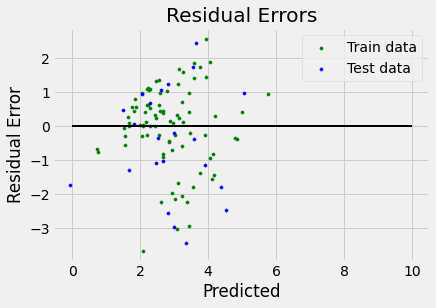

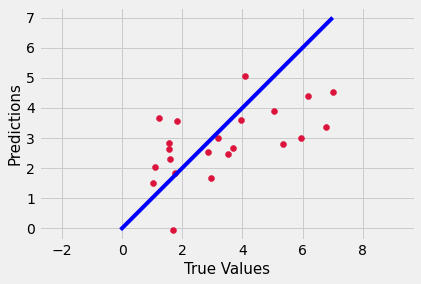

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tender
[9.89611834e-01 8.40596732e-03 1.93965226e-03 3.22721367e-05
 9.59739586e-06 6.47401411e-07 1.52492735e-08 7.54718292e-09
 3.73902500e-09 1.56186412e-09 5.90536832e-10 3.54370626e-10]
--------------------------------------------------
RMSE:  1.1419585791441007
R2:  0.3769008545451322
--------------------------------------------------
Actual ---> Predicted
1.66 ---> 3.36
1.07 ---> 1.86
1.07 ---> 1.3
1.57 ---> 3.35
1.15 ---> 1.83
1.06 ---> 1.7
3.58 ---> 3.0
5.39 ---> 2.95
2.89 ---> 2.5
1.27 ---> 2.07
3.02 ---> 3.07
3.4 ---> 2.05
1.01 ---> 1.4
4.26 ---> 3.1
2.12 ---> 2.88
1.11 ---> 1.81
4.3 ---> 2.93
1.19 ---> 1.62
3.47 ---> 5.18
5.48 ---> 3.85
1.06 ---> 2.3
2.7 ---> 3.35
--------------------------------------------------
Coefficients:  [-3.47551785e-07  2.54850085e-06  3.23770066e-06 -1.62240386e-05
  2.03411357e-04 -2.12802706e-04 -1.2795664

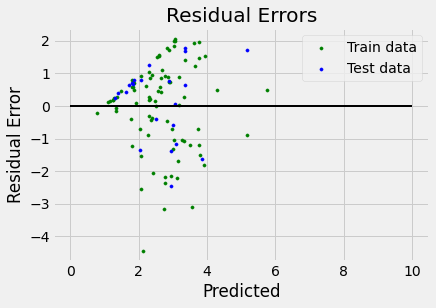

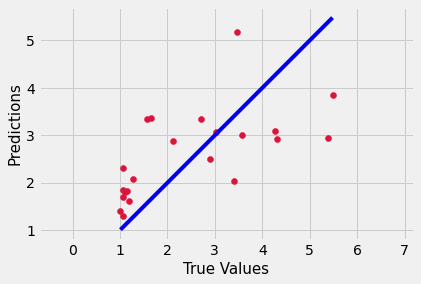

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````


In [88]:
toPredict = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender']
X = audio_df.loc[:, "tempo" : "frame_var"]
featureName = list(X)
X = pd.DataFrame(X)

for pre in toPredict:
  y = audio_df[pre]
  print(pre)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  pca = PCA(n_components = 12)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)

  explained_variance = pca.explained_variance_ratio_
  print(explained_variance)
  reg = linear_model.LinearRegression() #create linear regression object
  reg.fit(X_train, y_train) #train the model using the training sets

  pred = reg.predict(X_test)
  test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
  cnt = 0
  test_set_r2 = r2_score(y_test, pred)
  print('--------------------------------------------------')
  print('RMSE: ', test_set_rmse)
  print('R2: ', test_set_r2)
  print('--------------------------------------------------')
  print('Actual' + ' ---> ' + 'Predicted')
  for items in y_test.iteritems():
    print(str(items[1]) + ' ---> ' + str(round(pred[cnt], 2)))
    cnt += 1
  print('--------------------------------------------------')


  # regression coefficients
  print('Coefficients: ', reg.coef_)

  # plot for residual error
  ## setting plot style
  plt.style.use('fivethirtyeight')

  ## plotting residual errors in training data
  plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
              color = "green", s = 10, label = 'Train data')

  ## plotting residual errors in test data
  plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
              color = "blue", s = 10, label = 'Test data')

  ## plotting line for zero residual error
  plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)

  ## plotting legend
  plt.legend(loc = 'upper right')
  plt.xlabel('Predicted')
  plt.ylabel('Residual Error')

  ## plot title
  plt.title("Residual Errors")

  ## method call for showing the plot
  plt.show()
  print()
  print()

  plt.scatter(y_test, pred, c='crimson')

  p1 = max(max(pred), max(y_test))
  p2 = min(min(pred), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()
  print('````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````')

# PLS(with transformation)

['tempo', 'total_beats', 'average_beats', 'chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_var', 'chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var', 'chroma_cens_mean', 'chroma_cens_std', 'chroma_cens_var', 'melspectrogram_mean', 'melspectrogram_std', 'melspectrogram_var', 'mfcc_mean', 'mfcc_std', 'mfcc_var', 'mfcc_delta_mean', 'mfcc_delta_std', 'mfcc_delta_var', 'rms_mean', 'rms_std', 'rms_var', 'cent_mean', 'cent_std', 'cent_var', 'spec_bw_mean', 'spec_bw_std', 'spec_bw_var', 'contrast_mean', 'contrast_std', 'contrast_var', 'rolloff_mean', 'rolloff_std', 'rolloff_var', 'entropy_fft', 'entropy_welch', 'novelty_mean', 'novelty_std', 'novelty_var', 'poly_mean', 'poly_std', 'poly_var', 'tonnetz_mean', 'tonnetz_std', 'tonnetz_var', 'zcr_mean', 'zcr_std', 'zcr_var', 'harm_mean', 'harm_std', 'harm_var', 'perc_mean', 'perc_std', 'perc_var', 'frame_mean', 'frame_std', 'frame_var']
valence
R2 =  0.649530249254608



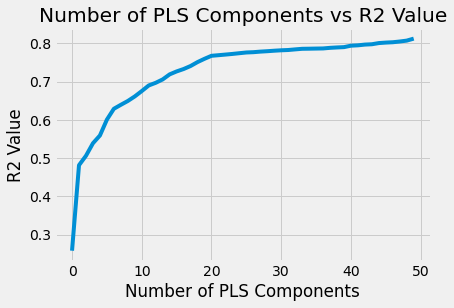

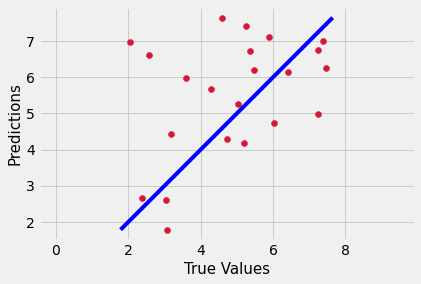

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
energy
R2 =  0.8785155323068579



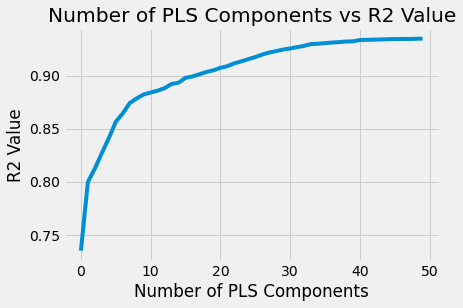

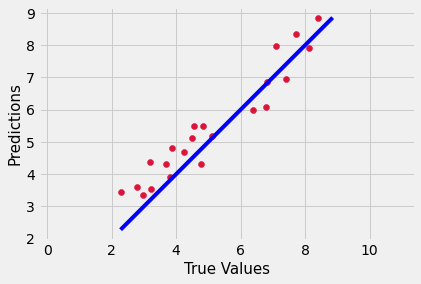

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tension
R2 =  0.7625448339428998



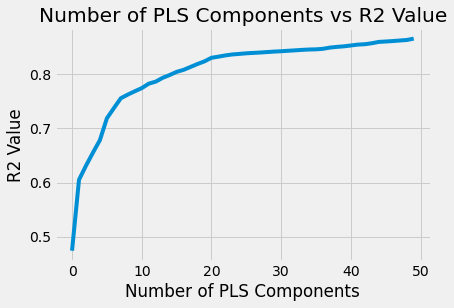

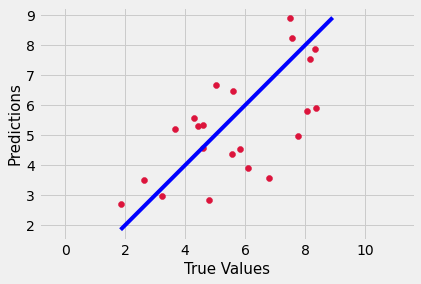

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
anger
R2 =  0.7481866614073115



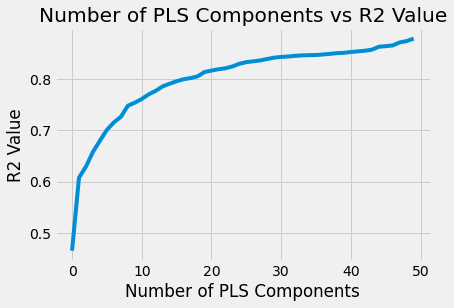

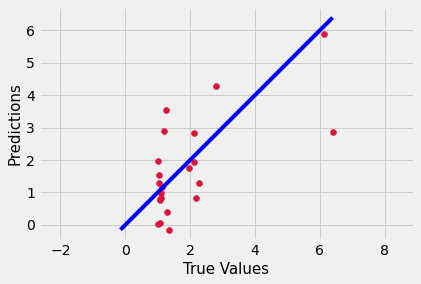

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
fear
R2 =  0.6954099979081134



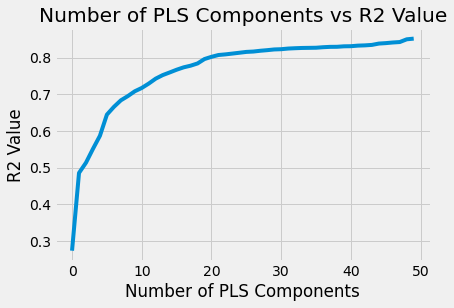

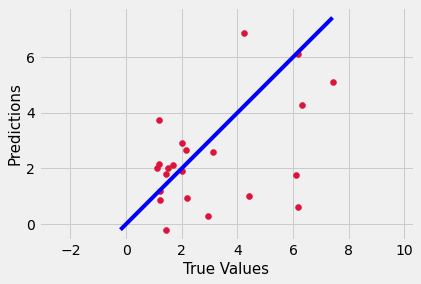

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
happy
R2 =  0.5624795777915929



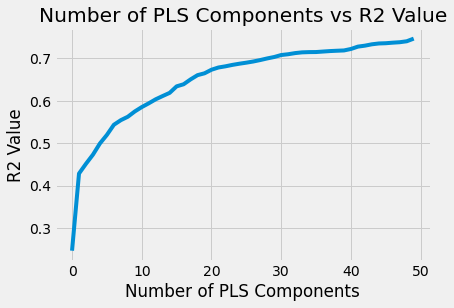

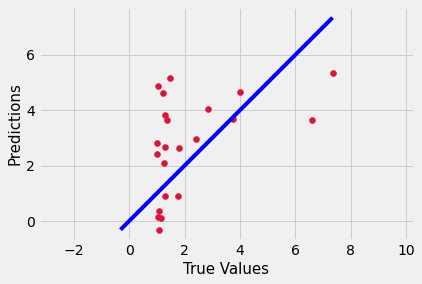

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
sad
R2 =  0.6414501550496174



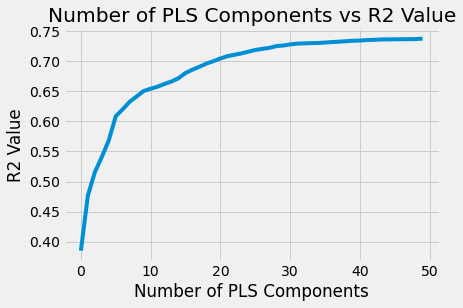

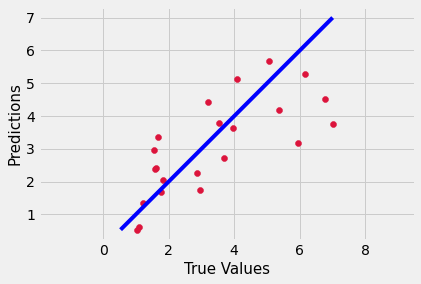

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tender
R2 =  0.7381717436877107



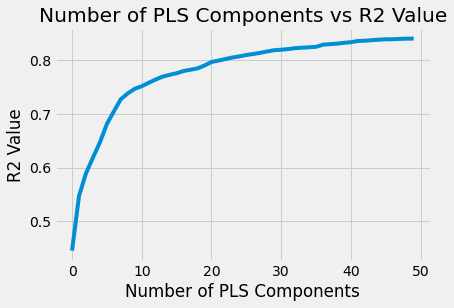

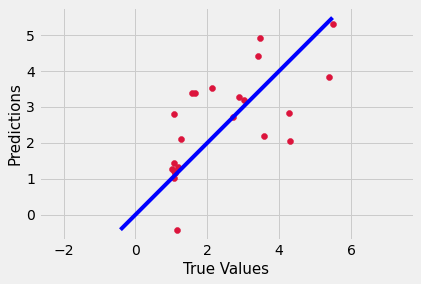

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
beauty
R2 =  0.7875764934599816



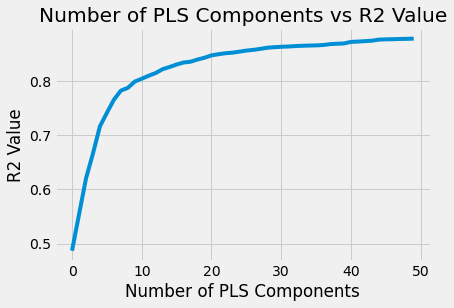

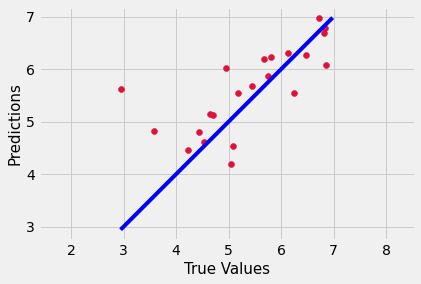

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
liking
R2 =  0.6860453943528466



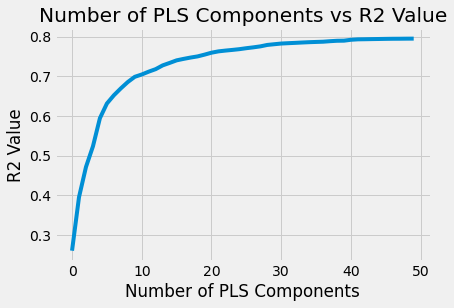

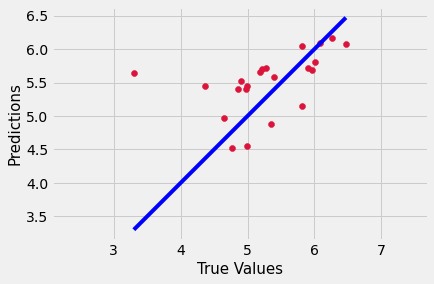

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````


In [94]:
X = audio_df.loc[:, 'tempo':'frame_var']
Y = audio_df.loc[:, 'valence':'liking']
featureName = list(X)
print(featureName)
for name in featureName:
    X[name], _ = yeojohnson(X[name])
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

for pre in Y.columns:
    y = Y[pre]
    print(pre)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    rmses = []
    r2s = []
    pred = []
    for com in range(1, 51):
        #calculate RMSE
        pls = PLSRegression(n_components = com)
        pls.fit(X_train, y_train)
        pred.append(pls.predict(X_test))
        rmses += [np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))]
        r2s += [pls.score(X_train, y_train)]
    
    print("R2 = ",r2s[8])
    print()
    plt.plot(r2s)
    plt.xlabel('Number of PLS Components')
    plt.ylabel('R2 Value')
    plt.title('Number of PLS Components vs R2 Value')
    plt.show()

    print()
    print()

    plt.scatter(y_test, pred[8], c='crimson')

    p1 = max(max(pred[8]), max(y_test))
    p2 = min(min(pred[8]), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    print('````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````')

# PLS(without transformation)

valence
R2 =  0.7088289197569514



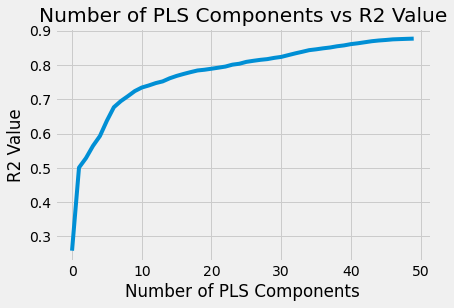

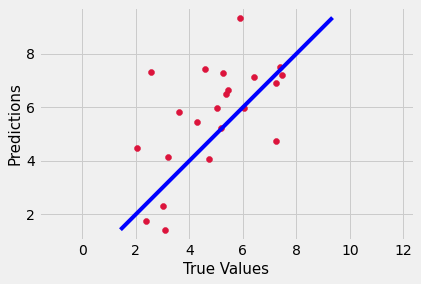

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
energy
R2 =  0.8758552131450715



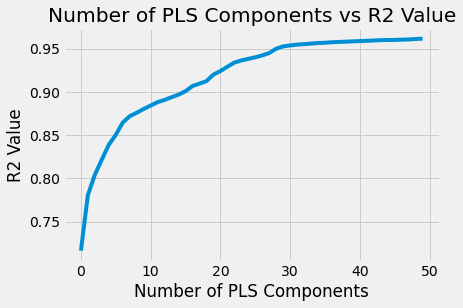

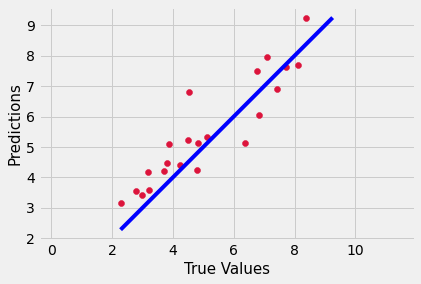

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tension
R2 =  0.7671551385015886



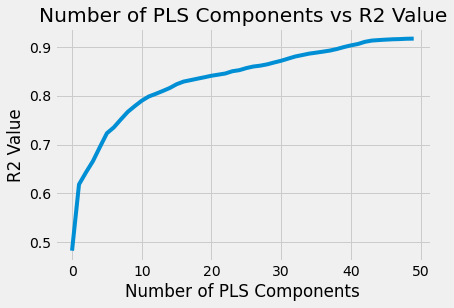

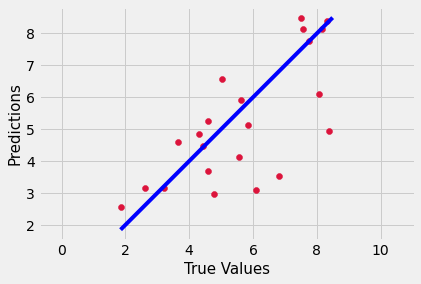

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
anger
R2 =  0.812620297474819



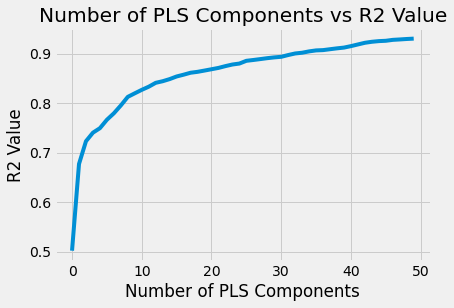

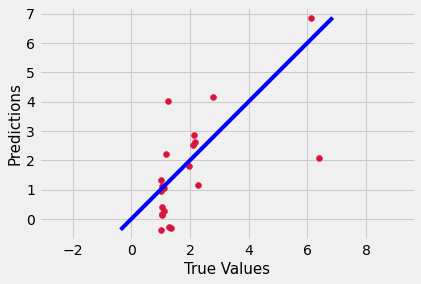

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
fear
R2 =  0.7445819149002844



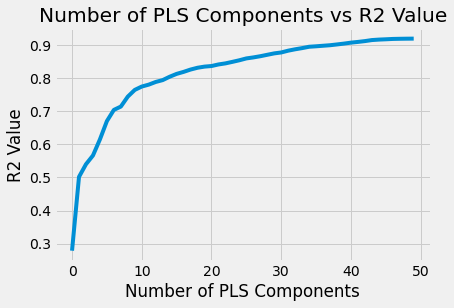

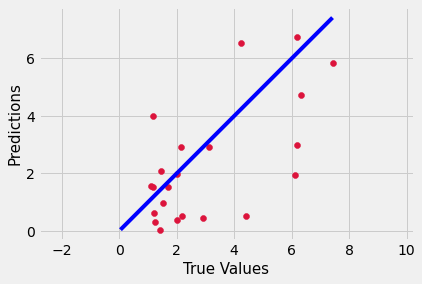

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
happy
R2 =  0.663196793177431



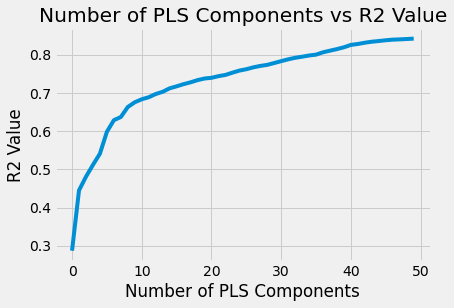

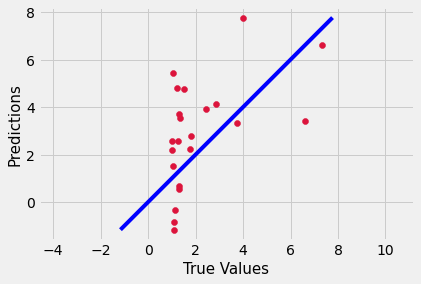

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
sad
R2 =  0.6709773242811276



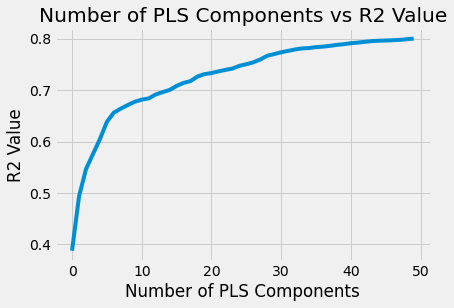

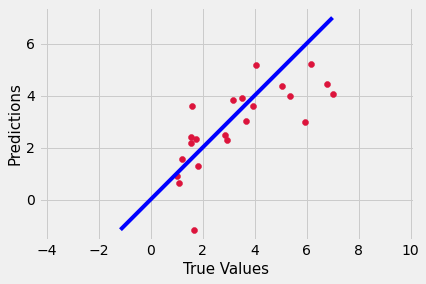

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tender
R2 =  0.6988246403157578



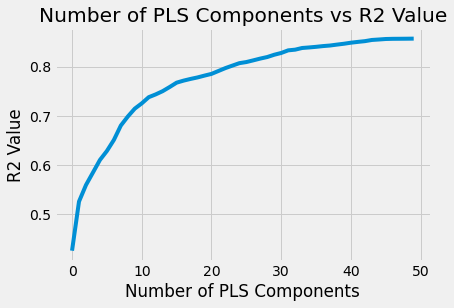

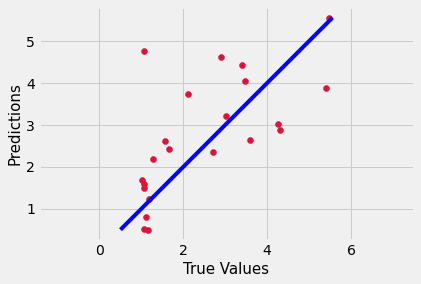

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
beauty
R2 =  0.766924190967175



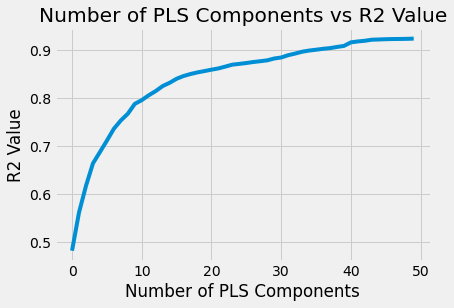

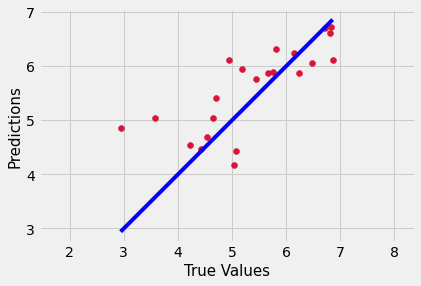

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
liking
R2 =  0.6790451855418473



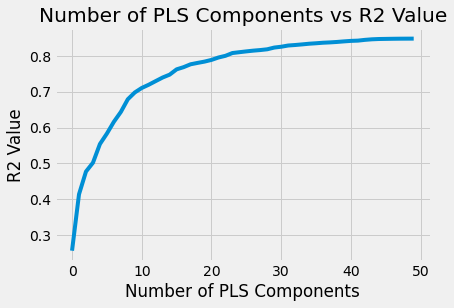

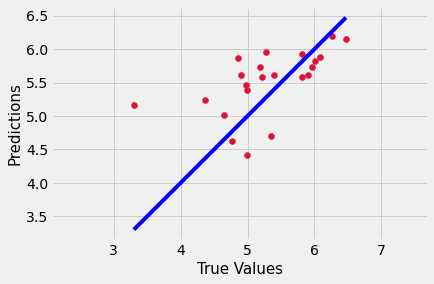

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````


In [90]:
from scipy.stats import yeojohnson
X = audio_df.loc[:, 'tempo':'frame_var']
Y = audio_df.loc[:, 'valence':'liking']
featureName = list(X)
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

for pre in Y.columns:
    y = Y[pre]
    print(pre)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    rmses = []
    r2s = []
    pred = []
    for com in range(1, 51):
        #calculate RMSE
        pls = PLSRegression(n_components = com)
        pls.fit(X_train, y_train)
        pred.append(pls.predict(X_test))
        rmses += [np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))]
        r2s += [pls.score(X_train, y_train)]
    
    print("R2 = ",r2s[8])
    print()
    plt.plot(r2s)
    plt.xlabel('Number of PLS Components')
    plt.ylabel('R2 Value')
    plt.title('Number of PLS Components vs R2 Value')
    plt.show()
    print()
    print()

    plt.scatter(y_test, pred[8], c='crimson')

    p1 = max(max(pred[8]), max(y_test))
    p2 = min(min(pred[8]), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    print('````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````')

# MLR(with transformation)

['tempo', 'total_beats', 'average_beats', 'chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_var', 'chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var', 'chroma_cens_mean', 'chroma_cens_std', 'chroma_cens_var', 'melspectrogram_mean', 'melspectrogram_std', 'melspectrogram_var', 'mfcc_mean', 'mfcc_std', 'mfcc_var', 'mfcc_delta_mean', 'mfcc_delta_std', 'mfcc_delta_var', 'rms_mean', 'rms_std', 'rms_var', 'cent_mean', 'cent_std', 'cent_var', 'spec_bw_mean', 'spec_bw_std', 'spec_bw_var', 'contrast_mean', 'contrast_std', 'contrast_var', 'rolloff_mean', 'rolloff_std', 'rolloff_var', 'entropy_fft', 'entropy_welch', 'novelty_mean', 'novelty_std', 'novelty_var', 'poly_mean', 'poly_std', 'poly_var', 'tonnetz_mean', 'tonnetz_std', 'tonnetz_var', 'zcr_mean', 'zcr_std', 'zcr_var', 'harm_mean', 'harm_std', 'harm_var', 'perc_mean', 'perc_std', 'perc_var', 'frame_mean', 'frame_std', 'frame_var']
Feature:  valence
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 

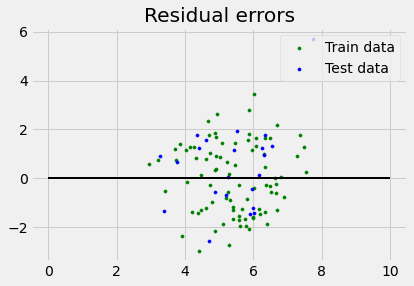

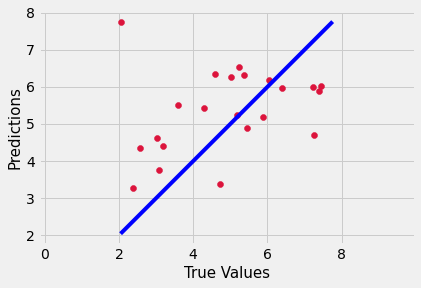

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  energy
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  1.1907460366358311
R2:  0.5860552306528086
--------------------------------------------------
Actual ---> Predicted
6.78 ---> 4.72
6.38 ---> 5.28
6.83 ---> 8.01
3.88 ---> 5.09
5.12 ---> 6.08
4.54 ---> 6.82
3.19 ---> 4.25
4.23 ---> 5.31
4.78 ---> 4.8
7.42 ---> 6.85
2.99 ---> 3.31
3.7 ---> 4.48
7.73 ---> 8.03
4.49 ---> 5.47
4.83 ---> 5.22
8.39 ---> 8.16
3.82 ---> 5.29
8.12 ---> 8.16
2.28 ---> 3.13
3.21 ---> 5.7
7.1 ---> 6.56
2.79 ---> 4.47
--------------------------------------------------
Coefficients:  [-0.01338089 -0.06808878  0.14464145 -0.01960981  0.05265686  0.17383287
  0.20344043 -0.31566328  0.134328

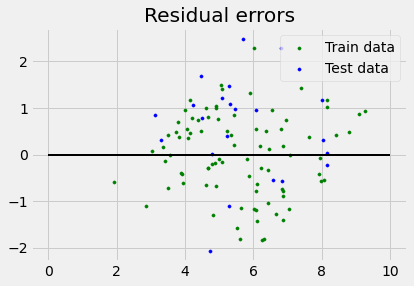

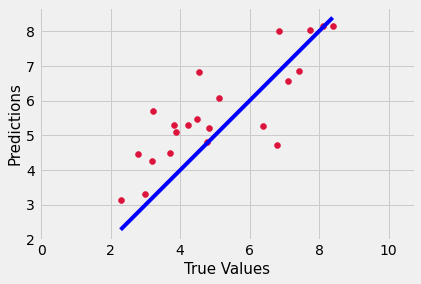

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  tension
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  1.5287805178927185
R2:  0.35689271318011173
--------------------------------------------------
Actual ---> Predicted
6.1 ---> 5.07
8.33 ---> 7.17
7.5 ---> 7.97
5.84 ---> 5.04
7.58 ---> 6.38
7.76 ---> 5.05
3.65 ---> 4.13
2.63 ---> 4.73
5.57 ---> 5.41
8.06 ---> 6.07
4.43 ---> 4.4
4.79 ---> 4.04
8.38 ---> 7.49
4.6 ---> 4.76
6.81 ---> 4.4
5.61 ---> 6.32
4.31 ---> 4.84
5.03 ---> 7.2
3.22 ---> 3.26
1.85 ---> 5.44
8.15 ---> 6.89
4.6 ---> 6.49
--------------------------------------------------
Coefficients:  [-0.01103998 -0.01421697  0.1302259  -0.02087781  0.10146878  0.36640555
  0.21618677 -0.28155429 -0.0872502

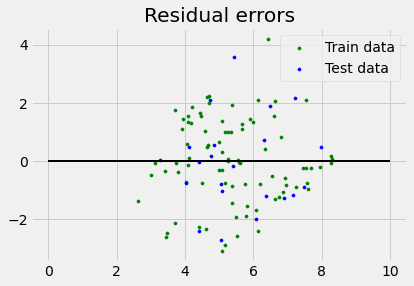

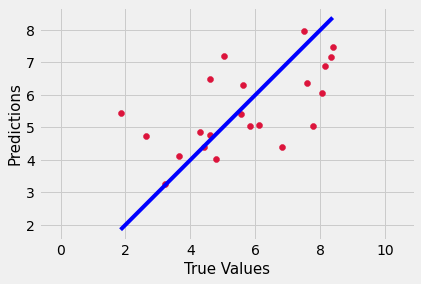

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  anger
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  1.19669224761617
R2:  0.341622531335774
--------------------------------------------------
Actual ---> Predicted
1.06 ---> 1.84
2.79 ---> 3.18
6.13 ---> 4.14
1.96 ---> 1.93
2.11 ---> 2.6
2.17 ---> -0.04
1.1 ---> 0.73
1.03 ---> 1.51
1.3 ---> 2.37
2.28 ---> 2.51
1.04 ---> 1.28
1.06 ---> 0.61
6.39 ---> 3.9
1.0 ---> 1.58
1.34 ---> 1.1
1.19 ---> 2.67
1.06 ---> 1.35
1.26 ---> 3.64
1.13 ---> 0.36
1.01 ---> 1.1
2.13 ---> 3.07
1.09 ---> 3.06
--------------------------------------------------
Coefficients:  [-0.00711601 -0.01688596  0.11957511 -0.01112211  0.07301951  0.27393079
  0.12430642 -0.23839929 -0.08172147  0.

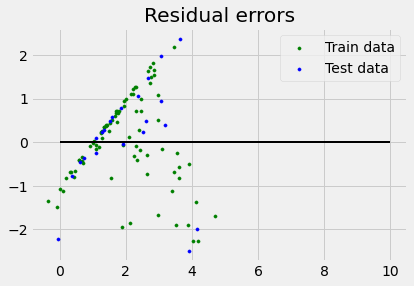

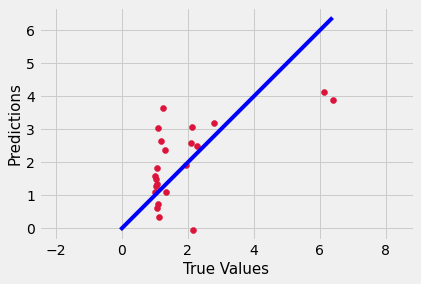

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  fear
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  2.047957991613198
R2:  0.005175075379284966
--------------------------------------------------
Actual ---> Predicted
2.02 ---> 3.09
7.42 ---> 4.45
4.24 ---> 5.2
3.13 ---> 2.74
6.19 ---> 3.66
6.17 ---> 0.06
1.69 ---> 1.25
1.21 ---> 2.01
2.19 ---> 2.83
6.12 ---> 2.6
2.02 ---> 2.25
1.43 ---> 1.01
4.4 ---> 3.95
1.23 ---> 2.05
2.93 ---> 1.85
1.17 ---> 2.03
1.51 ---> 1.34
1.19 ---> 3.67
1.45 ---> 1.82
1.1 ---> 2.83
6.34 ---> 4.14
2.16 ---> 4.75
--------------------------------------------------
Coefficients:  [-0.00279237  0.00663308  0.09568703 -0.05959656  0.11507752  0.35244423
  0.1683216  -0.01934722 -0.1011170

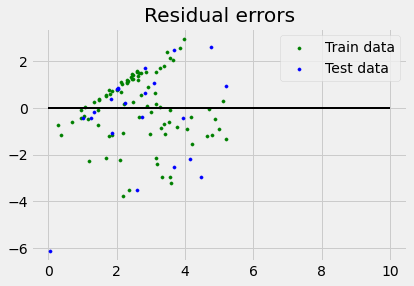

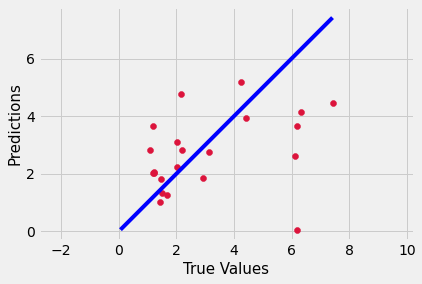

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  happy
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  1.9022785236064004
R2:  -0.19100811574652843
--------------------------------------------------
Actual ---> Predicted
4.0 ---> 2.05
1.09 ---> 0.47
1.07 ---> 2.49
1.02 ---> 2.39
1.28 ---> 2.22
1.04 ---> 6.46
1.25 ---> 2.82
3.75 ---> 3.14
1.79 ---> 1.79
1.28 ---> 3.3
1.04 ---> 1.38
1.36 ---> 3.33
1.21 ---> 3.0
2.43 ---> 2.86
1.49 ---> 3.62
7.34 ---> 4.64
1.77 ---> 3.04
6.6 ---> 3.56
1.02 ---> 1.92
2.85 ---> 3.63
1.31 ---> 1.98
1.15 ---> -0.4
--------------------------------------------------
Coefficients:  [-0.00438553 -0.06280188  0.00863247  0.03944585 -0.06429272 -0.2172372
  0.00752935  0.00187647  0.169687

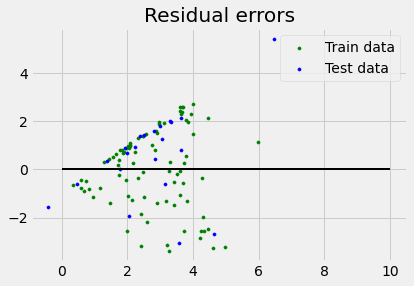

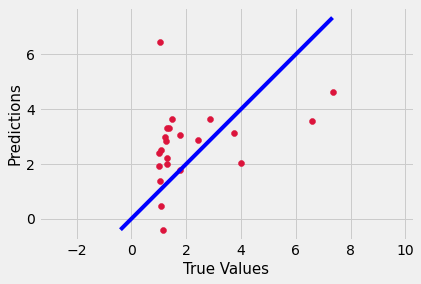

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  sad
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  1.4362012619521547
R2:  0.43601934530258113
--------------------------------------------------
Actual ---> Predicted
1.81 ---> 3.25
1.6 ---> 3.24
2.96 ---> 0.85
5.94 ---> 3.12
1.55 ---> 2.54
1.68 ---> 1.66
6.78 ---> 4.1
3.52 ---> 3.17
3.19 ---> 3.85
1.57 ---> 2.28
6.17 ---> 4.53
5.36 ---> 3.79
1.75 ---> 1.25
3.96 ---> 3.01
3.69 ---> 2.95
1.09 ---> 1.55
5.06 ---> 3.81
1.02 ---> 0.99
7.0 ---> 4.23
2.87 ---> 1.77
1.21 ---> 2.3
4.07 ---> 3.58
--------------------------------------------------
Coefficients:  [ 0.00792037  0.04464927 -0.09937808  0.04384043 -0.04129985 -0.12027068
 -0.17452215  0.07732477 -0.1307163 

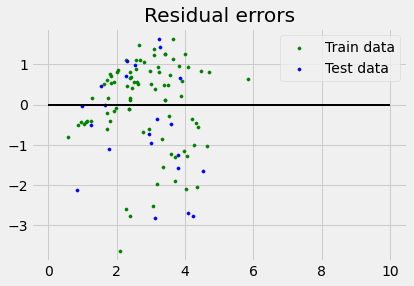

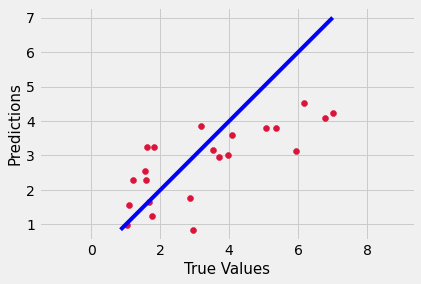

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  tender
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  1.1390918557628982
R2:  0.380025330083391
--------------------------------------------------
Actual ---> Predicted
1.66 ---> 3.2
1.07 ---> 1.45
1.07 ---> 0.96
1.57 ---> 3.13
1.15 ---> 1.88
1.06 ---> 2.96
3.58 ---> 3.32
5.39 ---> 3.03
2.89 ---> 2.54
1.27 ---> 1.88
3.02 ---> 3.54
3.4 ---> 3.37
1.01 ---> 0.9
4.26 ---> 2.82
2.12 ---> 3.42
1.11 ---> 1.37
4.3 ---> 2.58
1.19 ---> 1.07
3.47 ---> 4.45
5.48 ---> 3.37
1.06 ---> 1.77
2.7 ---> 2.21
--------------------------------------------------
Coefficients:  [ 0.01064996  0.01506538 -0.09050273  0.0211221  -0.04151118 -0.22801084
 -0.16093236  0.32687485  0.04990183

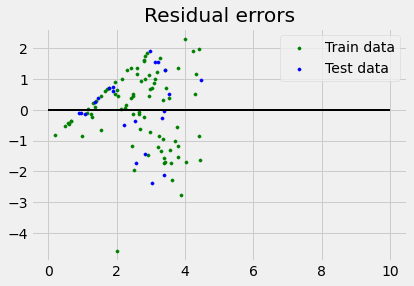

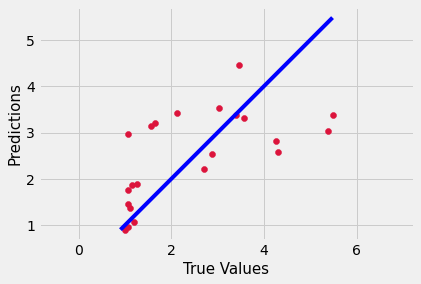

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  beauty
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  0.8703997449347848
R2:  0.3236297794478482
--------------------------------------------------
Actual ---> Predicted
5.76 ---> 5.83
3.58 ---> 4.84
5.08 ---> 4.34
5.67 ---> 5.81
4.22 ---> 5.11
2.94 ---> 5.55
6.86 ---> 6.04
6.83 ---> 5.8
5.18 ---> 5.71
4.65 ---> 5.23
6.47 ---> 6.15
6.14 ---> 5.92
4.71 ---> 4.34
6.24 ---> 5.53
4.95 ---> 5.85
4.54 ---> 4.87
5.81 ---> 5.88
5.04 ---> 4.27
6.72 ---> 6.61
6.82 ---> 5.64
4.43 ---> 5.34
5.45 ---> 5.34
--------------------------------------------------
Coefficients:  [ 0.00820225  0.00734884 -0.04765024  0.03858815 -0.01001573 -0.12891447
 -0.10399968  0.11903965  0.026

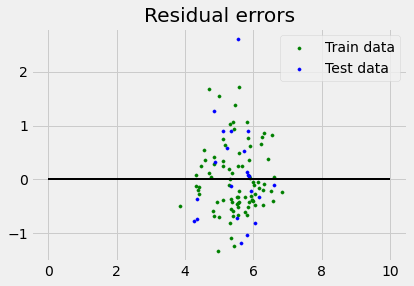

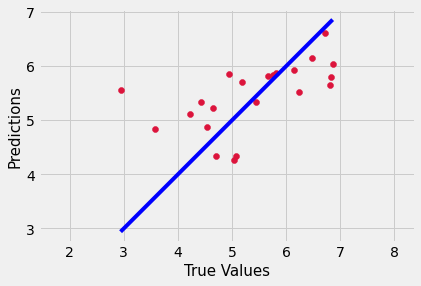

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  liking
[9.03303953e-01 6.95239786e-02 1.26899870e-02 6.10599615e-03
 3.46699293e-03 1.67432616e-03 1.36370146e-03 8.52330808e-04
 5.34932291e-04 1.38869841e-04 1.02366399e-04]
--------------------------------------------------
RMSE:  0.729649137759197
R2:  -0.06427745311243149
--------------------------------------------------
Actual ---> Predicted
6.01 ---> 5.55
4.37 ---> 5.15
5.35 ---> 5.01
5.21 ---> 5.44
4.76 ---> 5.3
3.3 ---> 5.84
5.96 ---> 5.71
6.47 ---> 5.48
4.85 ---> 5.61
4.99 ---> 5.43
5.9 ---> 5.65
5.82 ---> 5.67
4.97 ---> 4.75
5.81 ---> 5.22
5.18 ---> 5.49
4.65 ---> 5.12
5.27 ---> 5.85
4.99 ---> 4.66
6.08 ---> 5.82
6.26 ---> 5.52
5.39 ---> 5.67
4.9 ---> 5.36
--------------------------------------------------
Coefficients:  [ 0.00482868  0.00264068 -0.01071349  0.03519131  0.02381815 -0.05865766
 -0.02163889  0.01634491 -0.02169

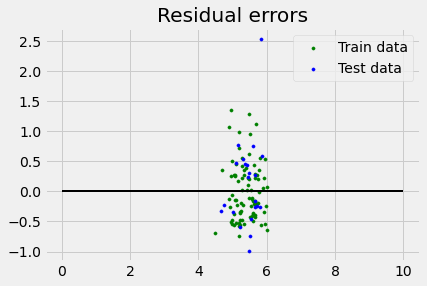

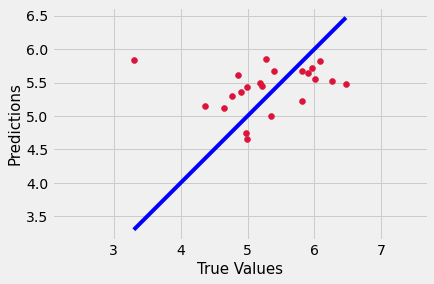

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````


In [91]:
toPredict = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender', 'beauty', 'liking']
X = audio_df.loc[:, "tempo" : "frame_var"]
featureName = list(X)
print(featureName)
for name in featureName:
    X[name], _ = yeojohnson(X[name])
X = pd.DataFrame(X)

for pre in toPredict:
  y = audio_df[pre]
  print("Feature: ", pre )
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
  pca = PCA(n_components = 11)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  explained_variance = pca.explained_variance_ratio_
  print(explained_variance)
  reg = linear_model.LinearRegression() #create linear regression object
  reg.fit(X_train, y_train) #train the model using the training sets
  pred = reg.predict(X_test)
  test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
  cnt = 0
  test_set_r2 = r2_score(y_test, pred)
  print('--------------------------------------------------')
  print('RMSE: ', test_set_rmse)
  print('R2: ', test_set_r2)
  print('--------------------------------------------------')
  print('Actual' + ' ---> ' + 'Predicted')
  for items in y_test.iteritems():
    print(str(items[1]) + ' ---> ' + str(round(pred[cnt], 2)))
    cnt += 1
  print('--------------------------------------------------')


  # regression coefficients
  print('Coefficients: ', reg.coef_)

  # variance score: 1 means perfect prediction
  print('Variance score: {}'.format(reg.score(X_test, y_test)))

  # plot for residual error

  ## setting plot style
  plt.style.use('fivethirtyeight')

  ## plotting residual errors in training data
  plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
              color = "green", s = 10, label = 'Train data')

  ## plotting residual errors in test data
  plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
              color = "blue", s = 10, label = 'Test data')

  ## plotting line for zero residual error
  plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)

  ## plotting legend
  plt.legend(loc = 'upper right')

  ## plot title
  plt.title("Residual errors")

  ## method call for showing the plot
  plt.show()

  print()
  print()

  plt.scatter(y_test, pred, c='crimson')

  p1 = max(max(pred), max(y_test))
  p2 = min(min(pred), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()
  print('````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````')
  

# MLR (Without PCA, with transformation)

['tempo', 'total_beats', 'average_beats', 'chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_var', 'chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var', 'chroma_cens_mean', 'chroma_cens_std', 'chroma_cens_var', 'melspectrogram_mean', 'melspectrogram_std', 'melspectrogram_var', 'mfcc_mean', 'mfcc_std', 'mfcc_var', 'mfcc_delta_mean', 'mfcc_delta_std', 'mfcc_delta_var', 'rms_mean', 'rms_std', 'rms_var', 'cent_mean', 'cent_std', 'cent_var', 'spec_bw_mean', 'spec_bw_std', 'spec_bw_var', 'contrast_mean', 'contrast_std', 'contrast_var', 'rolloff_mean', 'rolloff_std', 'rolloff_var', 'entropy_fft', 'entropy_welch', 'novelty_mean', 'novelty_std', 'novelty_var', 'poly_mean', 'poly_std', 'poly_var', 'tonnetz_mean', 'tonnetz_std', 'tonnetz_var', 'zcr_mean', 'zcr_std', 'zcr_var', 'harm_mean', 'harm_std', 'harm_var', 'perc_mean', 'perc_std', 'perc_var', 'frame_mean', 'frame_std', 'frame_var']
Feature:  valence
--------------------------------------------------
RMSE:  2.0827877915060675
R2:  -0.5702799

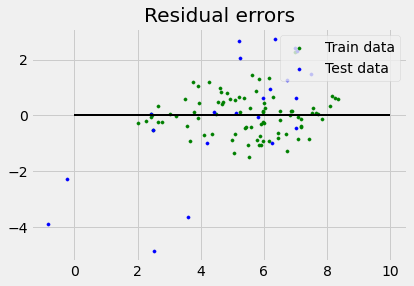

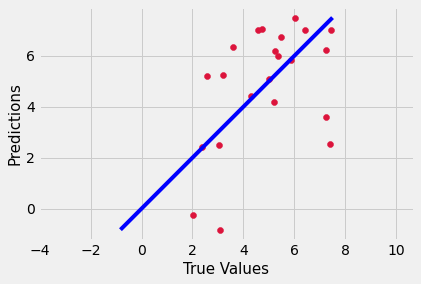

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  energy
--------------------------------------------------
RMSE:  0.9407712152246036
R2:  0.7416121123604922
--------------------------------------------------
Actual ---> Predicted
6.78 ---> 7.06
6.38 ---> 7.08
6.83 ---> 5.07
3.88 ---> 3.93
5.12 ---> 5.03
4.54 ---> 3.82
3.19 ---> 3.69
4.23 ---> 3.57
4.78 ---> 2.52
7.42 ---> 5.84
2.99 ---> 3.16
3.7 ---> 3.45
7.73 ---> 8.71
4.49 ---> 3.53
4.83 ---> 5.58
8.39 ---> 9.02
3.82 ---> 3.71
8.12 ---> 9.42
2.28 ---> 2.77
3.21 ---> 2.36
7.1 ---> 8.24
2.79 ---> 2.45
--------------------------------------------------
Coefficients:  [-8.05750646e-02  5.77922398e-02 -5.27864713e-02  1.04284530e+01
 -1.67365995e+02  1.48634537e+03 -5.07848219e+00  2.15786555e+03
 -2.42062787e+04 -5.69015158e+02  3.84371296e+01 -1.07415936e+03
  2.30765945e+00 -1.22411410e+01  5.22479419e+00  4.59400624e-02
  7.32766943e+

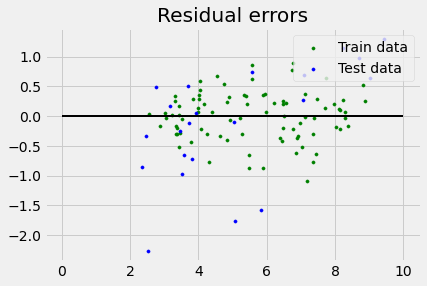

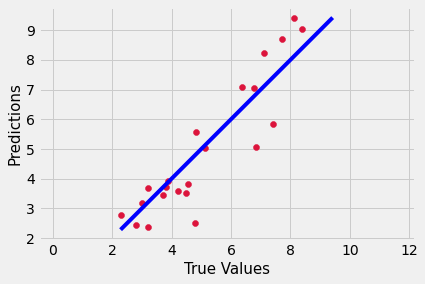

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  tension
--------------------------------------------------
RMSE:  1.8207613015827246
R2:  0.08778086089276405
--------------------------------------------------
Actual ---> Predicted
6.1 ---> 5.71
8.33 ---> 9.09
7.5 ---> 9.41
5.84 ---> 5.21
7.58 ---> 8.43
7.76 ---> 10.17
3.65 ---> 4.97
2.63 ---> 3.22
5.57 ---> 2.72
8.06 ---> 5.31
4.43 ---> 3.87
4.79 ---> 3.61
8.38 ---> 7.05
4.6 ---> 3.6
6.81 ---> 4.28
5.61 ---> 6.8
4.31 ---> 3.49
5.03 ---> 9.15
3.22 ---> 3.81
1.85 ---> 5.13
8.15 ---> 8.34
4.6 ---> 2.94
--------------------------------------------------
Coefficients:  [-8.18374257e-02 -9.37744702e-02  9.12203430e-02  2.08833941e+01
  2.12606836e+02 -1.89971695e+03  5.98969102e+01  7.49295944e+02
 -8.47644597e+03 -9.43783519e+02  1.40244141e+02 -2.63636649e+03
  1.12108279e+02 -3.95415018e+00 -2.59356570e+00 -8.68323446e-02
  3.28009618e+0

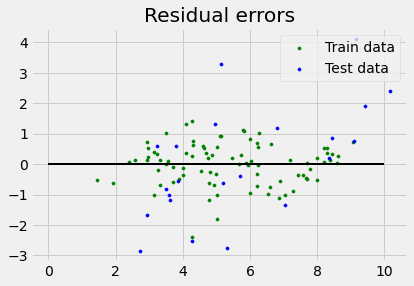

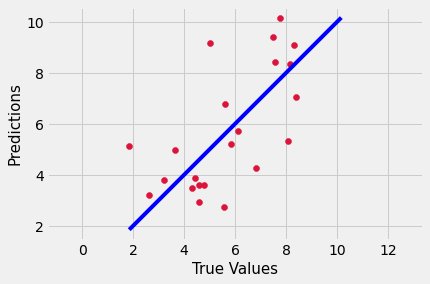

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  anger
--------------------------------------------------
RMSE:  2.014853880348406
R2:  -0.866367299959331
--------------------------------------------------
Actual ---> Predicted
1.06 ---> 2.79
2.79 ---> 3.55
6.13 ---> 8.58
1.96 ---> 2.45
2.11 ---> 2.04
2.17 ---> 6.38
1.1 ---> 1.08
1.03 ---> 1.8
1.3 ---> -0.1
2.28 ---> 0.79
1.04 ---> 2.62
1.06 ---> 0.69
6.39 ---> 4.03
1.0 ---> -1.46
1.34 ---> 0.15
1.19 ---> 1.53
1.06 ---> -1.08
1.26 ---> 4.8
1.13 ---> 1.9
1.01 ---> 5.22
2.13 ---> 1.68
1.09 ---> -1.27
--------------------------------------------------
Coefficients:  [ 1.33298552e-01 -2.41132506e-01  1.66764759e-01  3.32457471e+01
  1.46749478e+02 -1.30975583e+03  1.29178611e+01  3.41026300e+03
 -3.82720906e+04 -2.40992056e+03  2.13168704e+02 -5.15202870e+03
  7.50245939e+01  1.68253071e+01 -7.97740268e+00  7.65818203e-02
  1.59208282e+02 

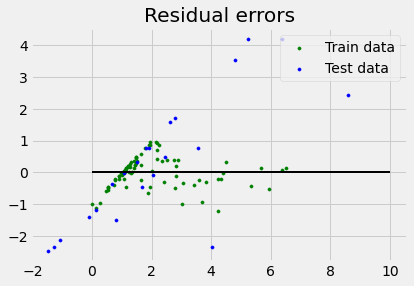

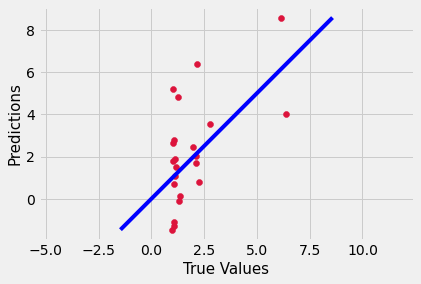

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  fear
--------------------------------------------------
RMSE:  2.504418230344051
R2:  -0.4877100012708231
--------------------------------------------------
Actual ---> Predicted
2.02 ---> 3.62
7.42 ---> 6.02
4.24 ---> 8.73
3.13 ---> 3.42
6.19 ---> 6.3
6.17 ---> 6.0
1.69 ---> 1.05
1.21 ---> 0.15
2.19 ---> -0.8
6.12 ---> 1.44
2.02 ---> 2.1
1.43 ---> 0.9
4.4 ---> 2.5
1.23 ---> -0.31
2.93 ---> 0.92
1.17 ---> 1.74
1.51 ---> -1.6
1.19 ---> 5.99
1.45 ---> 3.54
1.1 ---> 6.7
6.34 ---> 5.26
2.16 ---> 1.38
--------------------------------------------------
Coefficients:  [-3.54083446e-02 -3.43601332e-01  2.02883539e-01  2.96799679e+01
  3.44594171e+02 -3.07291842e+03  5.27846100e+01  1.55098562e+02
 -1.82382135e+03 -8.46236239e+02  1.17904156e+02 -2.24494095e+03
  8.56991181e+01  6.33730074e+00 -3.48352684e+00 -1.23478468e-03
  2.85318941e+02 -1.3

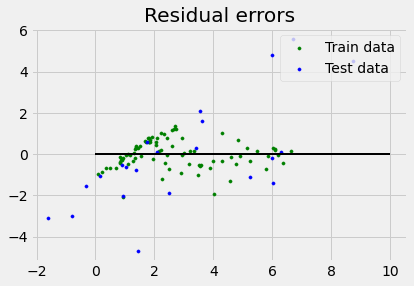

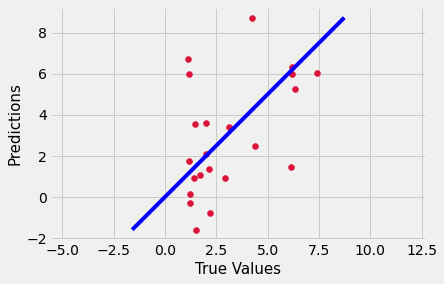

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  happy
--------------------------------------------------
RMSE:  2.2627471129415153
R2:  -0.6851499432786357
--------------------------------------------------
Actual ---> Predicted
4.0 ---> 2.9
1.09 ---> 0.17
1.07 ---> -3.97
1.02 ---> 1.5
1.28 ---> 0.61
1.04 ---> -3.36
1.25 ---> 1.58
3.75 ---> 2.69
1.79 ---> 2.34
1.28 ---> 4.29
1.04 ---> 0.16
1.36 ---> 2.28
1.21 ---> 2.71
2.43 ---> 3.4
1.49 ---> 4.58
7.34 ---> 6.02
1.77 ---> 3.54
6.6 ---> 2.67
1.02 ---> 2.03
2.85 ---> -1.23
1.31 ---> 2.53
1.15 ---> 2.03
--------------------------------------------------
Coefficients:  [-1.07403652e-01  2.12660145e-01 -1.53942037e-01 -2.81982239e+01
 -2.77050515e+02  2.46246170e+03 -2.74841157e+01 -1.01582115e+03
  1.14194381e+04  1.84701427e+03 -1.62958892e+02  3.86411820e+03
 -8.83364673e+01 -1.87579491e+01  1.08604952e+01 -1.98438546e-02
  4.24669216e+

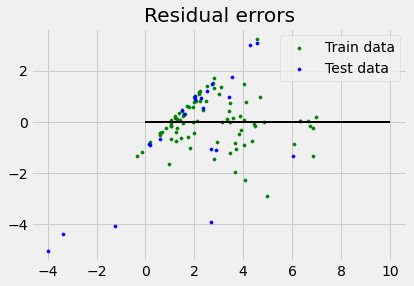

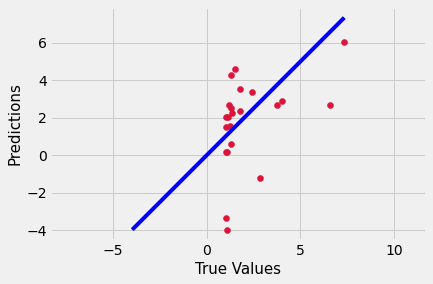

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  sad
--------------------------------------------------
RMSE:  1.3309339291087403
R2:  0.5156641765213188
--------------------------------------------------
Actual ---> Predicted
1.81 ---> 1.41
1.6 ---> 2.33
2.96 ---> 2.02
5.94 ---> 3.66
1.55 ---> 2.27
1.68 ---> 4.86
6.78 ---> 4.78
3.52 ---> 4.88
3.19 ---> 4.18
1.57 ---> 1.79
6.17 ---> 6.25
5.36 ---> 4.32
1.75 ---> 2.73
3.96 ---> 3.19
3.69 ---> 2.44
1.09 ---> 1.42
5.06 ---> 5.58
1.02 ---> 1.0
7.0 ---> 4.11
2.87 ---> 3.62
1.21 ---> 1.24
4.07 ---> 5.17
--------------------------------------------------
Coefficients:  [ 1.25039432e-01 -4.10837900e-02  5.12720031e-02  3.88959627e+00
 -1.39949060e+02  1.22760238e+03 -2.89700126e+00  2.77662222e+02
 -3.09102290e+03 -2.94652418e+02 -2.83396664e+01  5.37099331e+01
 -2.11925366e+01  1.58054337e+00 -9.63042732e-01  8.04824558e-03
 -3.10746616e+02  

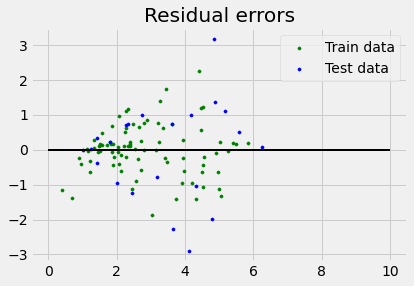

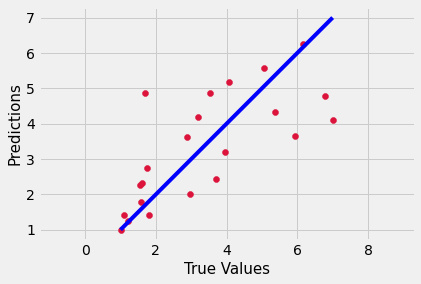

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  tender
--------------------------------------------------
RMSE:  1.3829612876055548
R2:  0.08614666898903
--------------------------------------------------
Actual ---> Predicted
1.66 ---> 1.53
1.07 ---> 0.47
1.07 ---> 3.12
1.57 ---> 2.5
1.15 ---> 0.16
1.06 ---> 3.23
3.58 ---> 1.86
5.39 ---> 3.91
2.89 ---> 5.53
1.27 ---> 2.35
3.02 ---> 3.83
3.4 ---> 4.08
1.01 ---> 0.77
4.26 ---> 4.32
2.12 ---> 3.12
1.11 ---> 0.32
4.3 ---> 2.86
1.19 ---> -1.51
3.47 ---> 3.73
5.48 ---> 5.68
1.06 ---> -0.25
2.7 ---> 4.64
--------------------------------------------------
Coefficients:  [ 2.65478458e-01 -2.63208029e-01  1.86371145e-01 -4.20293737e+00
  1.14865269e+02 -1.00646347e+03 -4.49265465e+01 -1.00019532e+03
  1.12568249e+04  7.01775881e+02 -4.31362544e+01  1.14349223e+03
 -5.55302626e+01 -2.13921464e+00  2.63840279e+00  1.62609107e-01
 -9.33795081e+02

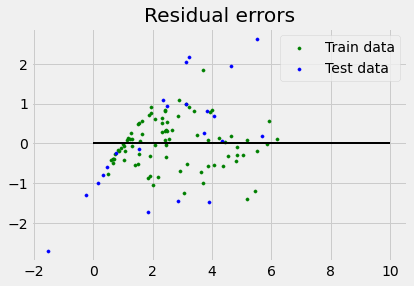

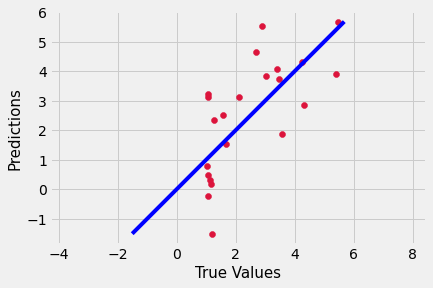

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  beauty
--------------------------------------------------
RMSE:  0.7164270557501753
R2:  0.5417621854826518
--------------------------------------------------
Actual ---> Predicted
5.76 ---> 5.25
3.58 ---> 4.73
5.08 ---> 4.07
5.67 ---> 5.62
4.22 ---> 4.46
2.94 ---> 3.65
6.86 ---> 5.62
6.83 ---> 6.64
5.18 ---> 5.65
4.65 ---> 4.91
6.47 ---> 6.64
6.14 ---> 5.77
4.71 ---> 5.37
6.24 ---> 4.99
4.95 ---> 5.68
4.54 ---> 4.63
5.81 ---> 6.84
5.04 ---> 3.88
6.72 ---> 6.28
6.82 ---> 6.45
4.43 ---> 4.1
5.45 ---> 6.26
--------------------------------------------------
Coefficients:  [ 1.15522016e-01 -5.46725017e-02  4.56188682e-02 -2.68100592e+00
 -1.47921887e+02  1.30940781e+03 -2.92074794e+01  7.32971372e+02
 -8.19351124e+03  4.37653886e+01 -5.15067830e+00  3.88114817e+01
 -5.04235028e+01 -1.80367995e+00  3.23540601e+00  9.71291620e-02
  6.70708529e

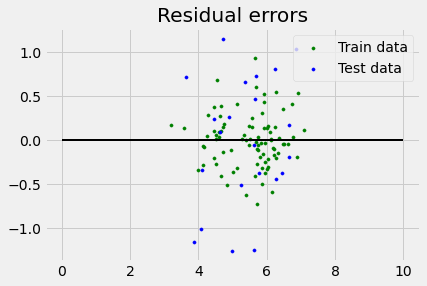

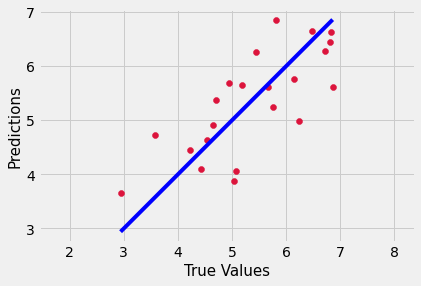

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Feature:  liking
--------------------------------------------------
RMSE:  0.7604220189467841
R2:  -0.15594210272284093
--------------------------------------------------
Actual ---> Predicted
6.01 ---> 5.75
4.37 ---> 5.14
5.35 ---> 4.67
5.21 ---> 5.14
4.76 ---> 4.47
3.3 ---> 5.21
5.96 ---> 4.98
6.47 ---> 5.86
4.85 ---> 5.03
4.99 ---> 5.24
5.9 ---> 6.32
5.82 ---> 5.6
4.97 ---> 5.88
5.81 ---> 4.21
5.18 ---> 5.35
4.65 ---> 4.91
5.27 ---> 5.66
4.99 ---> 4.73
6.08 ---> 5.95
6.26 ---> 7.06
5.39 ---> 5.05
4.9 ---> 6.22
--------------------------------------------------
Coefficients:  [ 1.37512570e-01 -1.02926352e-01  8.27777568e-02  2.38237827e+00
 -1.52626388e+02  1.35115067e+03 -2.70597826e+01  6.48775746e+02
 -7.25372985e+03 -2.98264525e+02  2.17786225e+01 -6.28140162e+02
 -3.11790108e+01 -1.31775577e+00  2.63481051e+00  8.93674245e-02
  3.25864064e+

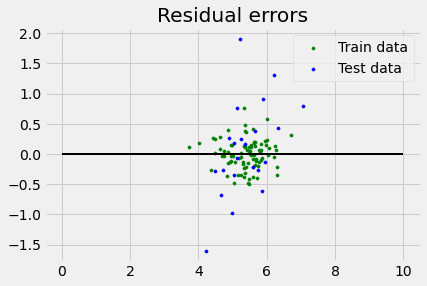

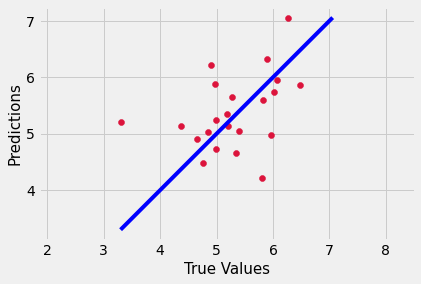

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````


In [92]:
toPredict = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender', 'beauty', 'liking']
X = audio_df.loc[:, "tempo" : "frame_var"]
featureName = list(X)
print(featureName)
for name in featureName:
    X[name], _ = yeojohnson(X[name])
X = pd.DataFrame(X)

for pre in toPredict:
  y = audio_df[pre]
  print("Feature: ", pre )

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


  reg = linear_model.LinearRegression() #create linear regression object
  reg.fit(X_train, y_train) #train the model using the training sets

  pred = reg.predict(X_test)
  test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
  cnt = 0
  test_set_r2 = r2_score(y_test, pred)
  print('--------------------------------------------------')
  print('RMSE: ', test_set_rmse)
  print('R2: ', test_set_r2)
  print('--------------------------------------------------')
  print('Actual' + ' ---> ' + 'Predicted')
  for items in y_test.iteritems():
    print(str(items[1]) + ' ---> ' + str(round(pred[cnt], 2)))
    cnt += 1
  print('--------------------------------------------------')


  # regression coefficients
  print('Coefficients: ', reg.coef_)

  # variance score: 1 means perfect prediction
  print('Variance score: {}'.format(reg.score(X_test, y_test)))

  # plot for residual error

  ## setting plot style
  plt.style.use('fivethirtyeight')

  ## plotting residual errors in training data
  plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
              color = "green", s = 10, label = 'Train data')

  ## plotting residual errors in test data
  plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
              color = "blue", s = 10, label = 'Test data')

  ## plotting line for zero residual error
  plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)

  ## plotting legend
  plt.legend(loc = 'upper right')

  ## plot title
  plt.title("Residual errors")

  ## method call for showing the plot
  plt.show()

  print()
  print()

  plt.scatter(y_test, pred, c='crimson')

  p1 = max(max(pred), max(y_test))
  p2 = min(min(pred), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()
  print('````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````')
  

# MLR (Without PCA, without transformation)

valence
--------------------------------------------------
RMSE:  3.009696463019506
R2:  -2.2789320953576393
--------------------------------------------------
Actual ---> Predicted
5.88 ---> 10.57
2.38 ---> 1.63
3.08 ---> -0.42
4.28 ---> 5.22
3.03 ---> 1.77
2.04 ---> 6.03
5.02 ---> 5.68
7.23 ---> 6.4
5.46 ---> 7.36
3.6 ---> 6.1
5.19 ---> 2.74
5.24 ---> 6.11
2.56 ---> 7.66
6.4 ---> 3.33
4.58 ---> 6.35
7.45 ---> 7.47
6.03 ---> 7.37
7.25 ---> 3.19
5.37 ---> 6.67
7.38 ---> 5.97
3.19 ---> -3.24
4.73 ---> -0.42
--------------------------------------------------
Coefficients:  [ 1.51067328e-02 -1.44022863e-05 -3.57434248e-03 -8.56456093e+00
  1.95022059e+02 -3.57581379e+02 -1.56796071e+01  1.33245441e+03
 -2.37312979e+03 -2.54391030e+02 -1.38550348e+02 -4.97607380e+02
 -2.40027779e+01  1.22428194e+00  1.32573048e-01 -1.83133206e-01
  1.74736929e-01 -6.65263661e-04  1.73564237e+01 -6.85879231e+00
  1.81423907e+00  1.67342982e+02  1.12898573e+01 -3.47469279e+03
 -1.87719343e-02  2.42721019e-02

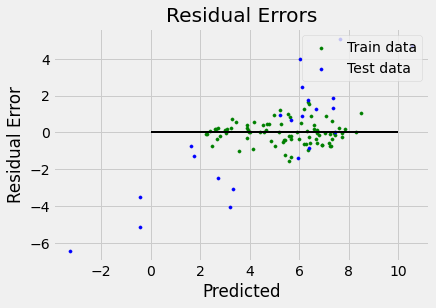

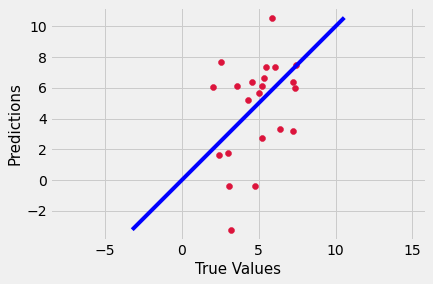

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
energy
--------------------------------------------------
RMSE:  3.1381475891780393
R2:  -1.8750859983567403
--------------------------------------------------
Actual ---> Predicted
6.78 ---> 6.63
6.38 ---> 7.05
6.83 ---> 4.99
3.88 ---> 4.09
5.12 ---> 4.08
4.54 ---> 17.41
3.19 ---> 5.21
4.23 ---> 4.7
4.78 ---> 0.35
7.42 ---> 5.57
2.99 ---> 4.65
3.7 ---> 4.29
7.73 ---> 10.07
4.49 ---> 2.96
4.83 ---> 5.58
8.39 ---> 8.91
3.82 ---> 5.76
8.12 ---> 8.13
2.28 ---> 3.83
3.21 ---> 3.55
7.1 ---> 7.93
2.79 ---> 2.71
--------------------------------------------------
Coefficients:  [-7.19359789e-04  2.48942879e-05 -2.57883266e-03  3.09254872e-01
  8.31998422e+01 -1.31276504e+02 -2.12042976e-01  3.88005516e+02
 -7.18134685e+02  4.09920524e+02 -1.75436993e+02  1.49029681e+03
 -2.06131982e+01 -1.90304712e+00  1.85955928e-01 -1.93466134e-02
 -5.25352507e-02  1.58

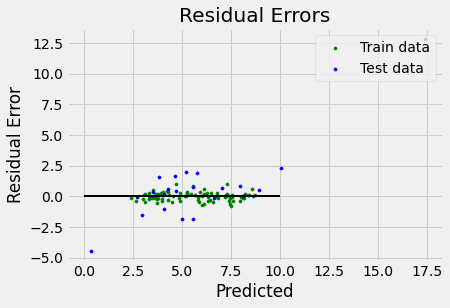

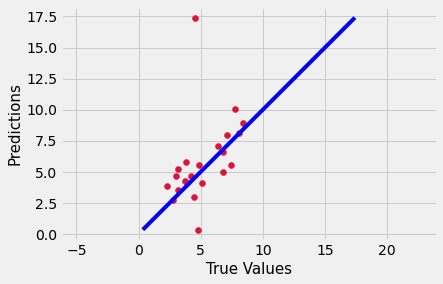

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tension
--------------------------------------------------
RMSE:  4.455453133461196
R2:  -4.462317129135086
--------------------------------------------------
Actual ---> Predicted
6.1 ---> 2.35
8.33 ---> 10.15
7.5 ---> 8.66
5.84 ---> 4.71
7.58 ---> 8.23
7.76 ---> 24.24
3.65 ---> 5.67
2.63 ---> 3.68
5.57 ---> 0.56
8.06 ---> 4.75
4.43 ---> 7.24
4.79 ---> 4.02
8.38 ---> 6.26
4.6 ---> 5.24
6.81 ---> 4.75
5.61 ---> 6.29
4.31 ---> 4.41
5.03 ---> 8.65
3.22 ---> 3.63
1.85 ---> 4.21
8.15 ---> 15.46
4.6 ---> 8.22
--------------------------------------------------
Coefficients:  [-1.18620395e-02  3.65254120e-05  1.71700313e-03  9.77083509e+00
 -9.04098098e+01  1.82071793e+02  2.05562838e+01 -8.95228228e+02
  1.52461206e+03  4.56363661e+02  2.13496904e+01  1.42209204e+03
  3.54726458e+00 -3.87012969e+00  1.13281561e-01  1.02822658e-01
 -1.06749073e-01  4.463

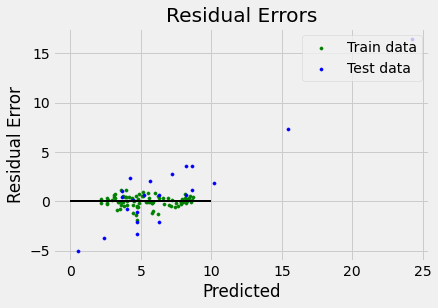

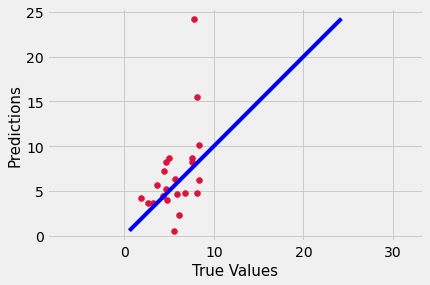

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
anger
--------------------------------------------------
RMSE:  2.378846025073073
R2:  -1.6016128533953715
--------------------------------------------------
Actual ---> Predicted
1.06 ---> -1.63
2.79 ---> 4.26
6.13 ---> 7.96
1.96 ---> 1.51
2.11 ---> 2.26
2.17 ---> 7.38
1.1 ---> 1.22
1.03 ---> 2.08
1.3 ---> -0.97
2.28 ---> 0.87
1.04 ---> 3.26
1.06 ---> 0.68
6.39 ---> 2.37
1.0 ---> 1.21
1.34 ---> 0.83
1.19 ---> 1.13
1.06 ---> 0.19
1.26 ---> 4.46
1.13 ---> 0.77
1.01 ---> 1.91
2.13 ---> 7.99
1.09 ---> 3.99
--------------------------------------------------
Coefficients:  [-1.02424354e-02  1.69794232e-05  6.99772450e-04  6.48065233e+00
 -8.94710766e+01  1.59932964e+02  2.83303263e+00 -8.54714812e+02
  1.51887277e+03  5.00338930e+02  2.67236648e+01  1.16586285e+03
  2.97435573e+00 -1.26433068e+00  1.36114926e-02  9.38454684e-02
 -4.82990069e-02  1.3586

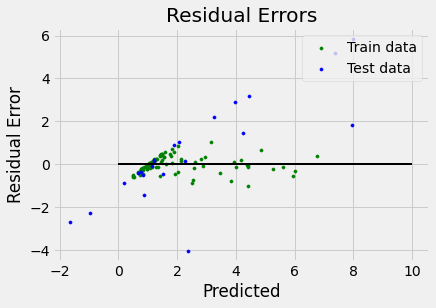

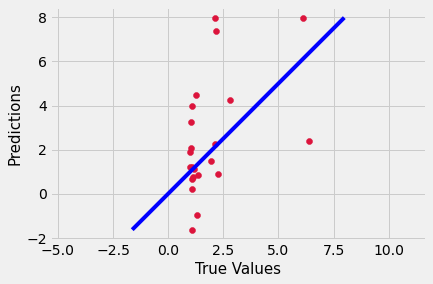

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
fear
--------------------------------------------------
RMSE:  3.2178938658678597
R2:  -1.456111063805539
--------------------------------------------------
Actual ---> Predicted
2.02 ---> -1.42
7.42 ---> 8.11
4.24 ---> 6.21
3.13 ---> 2.35
6.19 ---> 7.15
6.17 ---> 13.87
1.69 ---> 1.84
1.21 ---> 1.27
2.19 ---> -1.39
6.12 ---> 0.8
2.02 ---> 4.96
1.43 ---> 1.05
4.4 ---> 1.69
1.23 ---> 2.96
2.93 ---> 1.42
1.17 ---> 1.2
1.51 ---> 0.41
1.19 ---> 5.27
1.45 ---> 2.68
1.1 ---> 2.4
6.34 ---> 12.72
2.16 ---> 7.29
--------------------------------------------------
Coefficients:  [-2.68980781e-02  1.17679630e-04 -3.29537782e-03  1.09065354e+01
  6.07782398e+01 -7.61477921e+01  1.50279120e+01 -5.29797452e+02
  8.99365766e+02  3.80758988e+02 -7.16578324e+01  1.36805609e+03
  1.20422664e+01 -2.77503522e+00  7.37863418e-02  1.83651237e-01
 -1.55877640e-01  7.67229

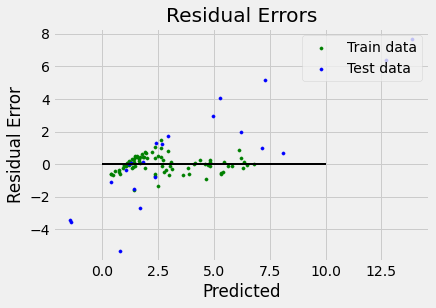

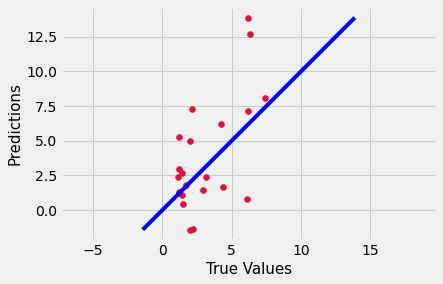

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
happy
--------------------------------------------------
RMSE:  3.974683043604777
R2:  -4.1996189198506
--------------------------------------------------
Actual ---> Predicted
4.0 ---> 8.35
1.09 ---> -1.03
1.07 ---> -2.98
1.02 ---> 2.06
1.28 ---> -0.66
1.04 ---> 5.74
1.25 ---> 2.09
3.75 ---> 2.35
1.79 ---> 0.59
1.28 ---> 3.44
1.04 ---> -1.18
1.36 ---> 2.59
1.21 ---> 6.58
2.43 ---> -1.54
1.49 ---> 3.57
7.34 ---> 6.93
1.77 ---> 3.57
6.6 ---> 2.08
1.02 ---> 2.73
2.85 ---> 3.85
1.31 ---> -9.98
1.15 ---> -6.68
--------------------------------------------------
Coefficients:  [ 1.92789249e-02 -6.93643636e-05  1.41693797e-03 -8.02974692e+00
  2.10902758e+02 -3.83080302e+02 -2.09086418e+01  1.85114584e+03
 -3.34183399e+03 -1.22507672e+02 -2.44288449e+02  1.04324916e+02
 -3.35881339e+01  6.23124526e-01  1.76342817e-01 -1.67715015e-01
  1.35096092e-02 -6.9

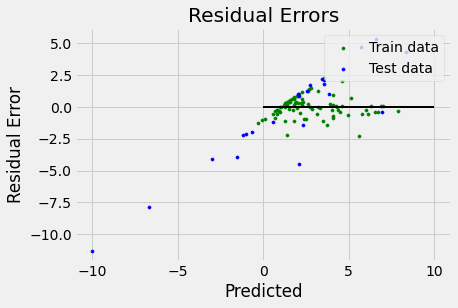

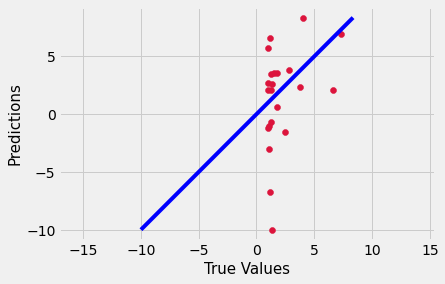

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
sad
--------------------------------------------------
RMSE:  3.8186468091188868
R2:  -2.9870582721521615
--------------------------------------------------
Actual ---> Predicted
1.81 ---> 4.74
1.6 ---> 0.53
2.96 ---> 4.73
5.94 ---> 4.53
1.55 ---> 2.28
1.68 ---> -14.09
6.78 ---> 3.09
3.52 ---> 3.64
3.19 ---> 5.0
1.57 ---> 2.83
6.17 ---> 3.78
5.36 ---> 3.63
1.75 ---> -0.5
3.96 ---> 4.89
3.69 ---> 2.87
1.09 ---> 1.91
5.06 ---> 2.5
1.02 ---> 1.64
7.0 ---> 4.11
2.87 ---> 2.87
1.21 ---> -0.75
4.07 ---> 5.8
--------------------------------------------------
Coefficients:  [ 8.01696269e-03 -5.39440739e-05  5.01304290e-03  3.09491678e+00
 -3.06066646e+02  5.15902129e+02  7.39023364e+00 -1.01264845e+03
  1.82368008e+03 -3.97730449e+02  3.15229657e+02 -1.76588328e+03
  1.55001860e+01  2.42935369e+00 -2.66090012e-01 -7.21670322e-03
 -8.90948349e-02  5.771372

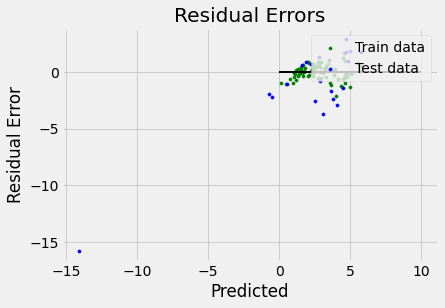

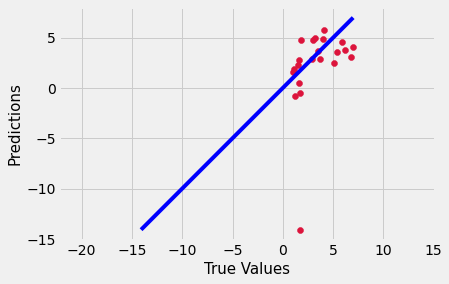

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
tender
--------------------------------------------------
RMSE:  2.8631171702515723
R2:  -2.9168297557261154
--------------------------------------------------
Actual ---> Predicted
1.66 ---> 1.5
1.07 ---> 0.04
1.07 ---> 1.77
1.57 ---> 3.04
1.15 ---> 0.69
1.06 ---> -9.83
3.58 ---> 1.98
5.39 ---> 4.63
2.89 ---> 8.84
1.27 ---> 3.69
3.02 ---> 1.62
3.4 ---> 3.71
1.01 ---> -0.06
4.26 ---> 3.86
2.12 ---> 2.78
1.11 ---> 0.07
4.3 ---> 3.57
1.19 ---> -0.5
3.47 ---> 3.75
5.48 ---> 3.37
1.06 ---> 0.32
2.7 ---> 2.7
--------------------------------------------------
Coefficients:  [ 6.07978184e-03 -2.62783718e-05 -4.26539907e-04 -6.90874471e+00
  6.47747589e+01 -1.35175254e+02 -9.35273008e+00  3.27312046e+02
 -5.20762246e+02 -2.06653517e+02 -3.95059746e+00 -7.55697786e+02
  1.02673608e+01  3.07469826e+00 -1.39496771e-01 -2.97164098e-02
  9.48767682e-02 -4.5193

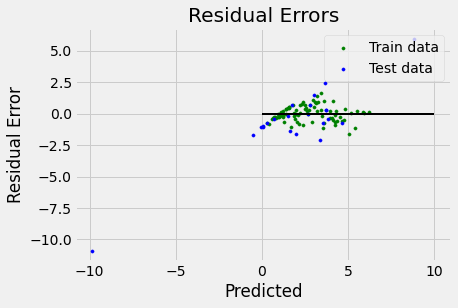

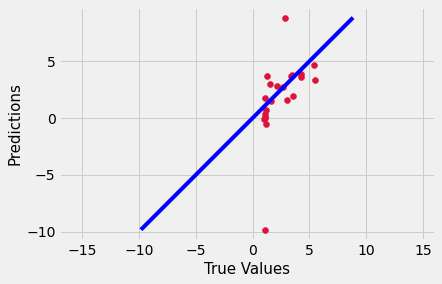

````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````


In [93]:
toPredict = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender']
X = audio_df.loc[:, "tempo" : "frame_var"]
featureName = list(X)
# print(featureName)
X = pd.DataFrame(X)

for pre in toPredict:
  y = audio_df[pre]
  print(pre)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  reg = linear_model.LinearRegression() #create linear regression object
  reg.fit(X_train, y_train) #train the model using the training sets

  pred = reg.predict(X_test)
  test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
  cnt = 0
  test_set_r2 = r2_score(y_test, pred)
  print('--------------------------------------------------')
  print('RMSE: ', test_set_rmse)
  print('R2: ', test_set_r2)
  print('--------------------------------------------------')
  print('Actual' + ' ---> ' + 'Predicted')
  for items in y_test.iteritems():
    print(str(items[1]) + ' ---> ' + str(round(pred[cnt], 2)))
    cnt += 1
  print('--------------------------------------------------')

  # regression coefficients
  print('Coefficients: ', reg.coef_)

  # variance score: 1 means perfect prediction
  # print('Variance score: {}'.format(reg.score(X_test, y_test)))

  # plot for residual error

  ## setting plot style
  plt.style.use('fivethirtyeight')

  ## plotting residual errors in training data
  plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
              color = "green", s = 10, label = 'Train data')

  ## plotting residual errors in test data
  plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
              color = "blue", s = 10, label = 'Test data')

  ## plotting line for zero residual error
  plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)

  ## plotting legend
  plt.legend(loc = 'upper right')
  plt.xlabel('Predicted')
  plt.ylabel('Residual Error')

  ## plot title
  plt.title("Residual Errors")

  ## method call for showing the plot
  plt.show()
  print()
  print()

  # plt.figure(figsize=(10,10))
  plt.scatter(y_test, pred, c='crimson')

  p1 = max(max(pred), max(y_test))
  p2 = min(min(pred), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()
  print('````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````')